# 1 CTAB on AU 111 21x12x2 LAMMPS

This notebook contains a set of code snippets and functions, supporting analysis of LAMMPS output.
Exemplarily, the minimization, equilibration and production trajectories of one CTA+ ion in
the vicinity of a 111 gold layer are investigated.

With the help of numpy, pandas and matplotlib, LAMMPS output energy conbtributions are evaluated and plotted.
With the help of ase, parmed, nglview and ipywidgets, trajectories are visulized.

With the help of ase and asap, radial distribution functions, distances, displacements and diffusivities are evaluated.

## 1. Header

### 1.1. Jupyter Notebook-related "magic" commands

In [1]:
## preferred installation method for netcdf on NEMO locally:
# module load mpi/openmpi/2.1-gnu-5.2
# module load {...}
# export CPPFLAGS="${CPPFLAGS} -I${MPI_INC_DIR}"
# export LDFLAGS="${LDFLAGS} -L${MPI_LIB_DIR}"
# pip install --user netCDF4

## alternatively:
# pip install --user --global-option=build_ext --global-option="-L${MPI_INC_DIR}" netCDF4

In [2]:
%lsmagic # notebook commands

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%python  %%python

In [3]:
# list environment variables, like bash's 'printenv'
%env

{'BASH_FUNC_module()': '() {  eval $(/opt/bwhpc/common/admin/modules/module-wrapper/modulecmd bash $*)\n}',
 'CC': 'gcc',
 'CFLAGS': '-O3 -fPIC',
 'CLICOLOR': '1',
 'CMAKE_BIN_DIR': '/opt/bwhpc/common/devel/cmake/3.9.0/bin',
 'CMAKE_DOC_DIR': '/opt/bwhpc/common/devel/cmake/3.9.0/doc',
 'CMAKE_HOME': '/opt/bwhpc/common/devel/cmake/3.9.0',
 'CMAKE_MAN_DIR': '/opt/bwhpc/common/devel/cmake/3.9.0/man',
 'CMAKE_VERSION': '3.9.0',
 'CPATH': '/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_modules/lammps/16Mar18-gnu-5.2-openmpi-2.1/include',
 'CPPFLAGS': '-I/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_modules/lammps/16Mar18-gnu-5.2-openmpi-2.1/include',
 'CXX': 'g++',
 'CXXFLAGS': '-O3 -fPIC',
 'DISPLAY': 'localhost:13.0',
 'ENV': '/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17',
 'F77': 'gfortran',
 'F90': 'gfortran',
 'FC': 'gfortran',
 'FCFLAGS': '-O3 -fPIC',
 'GIT_PAGER': 'cat',
 'GMXBIN': '/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_modules/gromacs/2018.1-gnu-5.2/bin',
 

In [4]:
%load_ext memory_profiler

In [5]:
# for some reason, nglview sometimes changes into some temporary directory
# therefore ALWAY use absolute filenames and paths
# %cd /work/ws/nemo/fr_jh1130-201708-0/jobs/lmplab/sds/201806/1_SDS_on_AU_100_1x4x4/

### 1.2. Imports

In [6]:
# system basics
import os
absolute_prefix = os.getcwd() # might be handy to get back to the initial working directory at any point
os.sep # '\' ond windows and '/' on unix-like

'/'

In [7]:
# data analysis 
import pandas as pd 
import numpy as np

import ase
from asap3.analysis.rdf import RadialDistributionFunction

# file formats, input - output
import ase.io
from ase.io import read
import parmed as pmd

# visualization
from ase.visualize import view
import nglview as nv
import matplotlib.pyplot as plt
import ipywidgets # just for jupyter notebooks

### 1.3. Global options

In [8]:
%matplotlib inline

In [9]:
# matplotlib settings

# expecially for presentation, larger font settings for plotting are recommendable
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure titlex

plt.rcParams["figure.figsize"] = (11,7) # the standard figure size

In [73]:
# numpy truncates the output of large array above the treshold length
np.set_printoptions(threshold=100) 

### 1.4. Definition of helper functions

In [11]:
# conversion units, only for better readability
fs = 1e-15 # s
ps = 1e-12 # s

In [12]:
AA = 1e-10 # m

In [13]:
def fullprint(*args, **kwargs):
    """prints a long numpy array without altering numpy treshold options permanently"""
    from pprint import pprint
    opt = np.get_printoptions()
    np.set_printoptions(edgeitems=3,infstr='inf', 
        linewidth=75, nanstr='nan', precision=8,
        suppress=False, threshold=100000, formatter=None)
    pprint(*args, **kwargs)
    np.set_printoptions(**opt)

In [14]:
def runningMeanFast(x, N):
    """a quick way to compute the running or rolling mean on a numpy array"""
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

In [15]:
def running_mean(x, N):
    """another quick way to compute the running or rolling mean on a numpy array"""
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [16]:
def subplotPosition(rows,cols):
    """generator for subplot positions"""
    for p in range(0,rows*cols):
        yield rows*100+cols*10+p+1

def addSubplot(x, y,
               title=None, xlabel=None, ylabel=None, legend=None,
               fig=None, ax=None, pos=None, figsize=(8,5)):
    """facilitate matplotlib figure & subplot creation. only one data series per call."""
    
    if not pos:
        pos = 111
    if not fig and not ax:
        fig = plt.figure(figsize=figsize)
    elif not fig and ax:
        fig = ax.get_figure()
    if not ax:
        ax = fig.add_subplot(pos)
      
    if legend:
        ax.plot(x,y,label=legend)
    else:
        ax.plot(x,y)
               
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
    if legend:
        ax.legend()
        
    return fig, ax

In [17]:
def makeThermoPlotsFromDataFrame(df, fig=None,
        time_label          = r'$\frac{\mathrm{Steps}}{2 \mathrm{fs}}$',
        temperature_label   = r'$\frac{T}{\mathrm{K}}$',
        pressure_label      = r'$\frac{P}{\mathrm{atm}}$',
        energy_label        = r'$\frac{E}{\mathrm{Kcal} \cdot \mathrm{mole}^{-1}}$'):
    """Automizes the plotting of thermo output."""

    rows = 3
    cols = 2
    if fig == None:
        fig = plt.figure(figsize=(cols*8,rows*5))
    
    def subplotPosition(rows,cols):
        for p in range(0,rows*cols):
            yield rows*100+cols*10+p+1
     
    def addSubplot(df,fig,pos,title,xlabel,ylabel):
        ax = fig.add_subplot(pos)
        df.plot(ax=ax) # taimed temperature
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    
    pos = subplotPosition(rows,cols)
    
    # sum up intramolecular contributions 
    df["E_intramolecular"] = df[["E_bond","E_angle","E_dihed"]].sum(axis=1)
    
    addSubplot(df[["Temp"]],
               fig, next(pos), "Temperature", time_label, temperature_label)
    addSubplot(df[["Press"]],
               fig, next(pos), "Pressure", time_label, pressure_label)
   
    # intramolecular contributions (without angle)
    addSubplot(df[["E_intramolecular","E_bond","E_angle","E_dihed"]],
               fig, next(pos), "Intramolecular energies", time_label, energy_label)
    # intermolecular ("non-bonded") energy contribtutions
    # E_pair is the sum of the three latter, just as E_intramolecular in the plot above
    addSubplot(df[["E_pair","E_vdwl","E_coul","E_long"]],
                fig, next(pos), "Intermolecular (non-bonded) energies", time_label, energy_label)
    
    # visualize the difference between total and non-bonded potential:
    addSubplot(df[["PotEng","E_pair"]],
               fig, next(pos), "Total potential and non-bonded potential", time_label, energy_label)
    
    addSubplot(df[["TotEng","KinEng","PotEng"]],
               fig, next(pos), "Total, kinetic and potential energies", time_label, energy_label)
    
    fig.tight_layout()
    return fig

In [18]:
def makeRollingAverageThermoPlotsFromDataFrame(df, fig=None,
        time_label          = r'$\frac{\mathrm{Steps}}{2 \mathrm{fs}}$',
        temperature_label   = r'$\frac{T}{\mathrm{K}}$',
        pressure_label      = r'$\frac{P}{\mathrm{atm}}$',
        energy_label        = r'$\frac{E}{\mathrm{Kcal} \cdot \mathrm{mole}^{-1}}$',
        window = 1000):
    """Automizes the plotting of thermo output. Displays the rolling average with default window = 1000."""
    
    rows = 3
    cols = 2
    if fig == None:
        fig = plt.figure(figsize=(cols*8,rows*5))
    
    def subplotPosition(rows,cols):
        for p in range(0,rows*cols):
            yield rows*100+cols*10+p+1
     
    def addSubplot(df,fig,pos,title,xlabel,ylabel):
        ax = fig.add_subplot(pos)
        df.plot(ax=ax)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    
    pos = subplotPosition(rows,cols)
    
    # sum up intramolecular contributions 
    df["E_intramolecular"] = df[["E_bond","E_angle","E_dihed"]].sum(axis=1)
    
    addSubplot(df[["Temp"]].rolling(window=window,center=True).mean(),
               fig, next(pos), "Temperature", time_label, temperature_label)
    addSubplot(df[["Press"]].rolling(window=window,center=True).mean(),
               fig, next(pos), "Pressure", time_label, pressure_label)
   
    # intramolecular contributions (without angle)
    addSubplot(
      df[["E_intramolecular","E_bond","E_angle","E_dihed"]].rolling(window=window,center=True).mean(),
      fig, next(pos), "Intramolecular energies", time_label, energy_label)
    # intermolecular ("non-bonded") energy contribtutions
    # E_pair is the sum of the three latter, just as E_intramolecular in the plot above
    addSubplot(df[["E_pair","E_vdwl","E_coul","E_long"]].rolling(window=window,center=True).mean(),
                fig, next(pos), "Intermolecular (non-bonded) energies", time_label, energy_label)
    
    # visualize the difference between total and non-bonded potential:
    addSubplot(df[["PotEng","E_pair"]].rolling(window=window,center=True).mean(),
               fig, next(pos), "Total potential and non-bonded potential", time_label, energy_label)
    
    addSubplot(df[["TotEng","KinEng","PotEng"]].rolling(window=window,center=True).mean(),
               fig, next(pos), "Total, kinetic and potential energies", time_label, energy_label)
    
    fig.tight_layout() # tigh_layout avoids label overlap
    return fig

In [19]:
# ASE by default infers elements from LAMMPS atom types, in our case they are unrelated
# During preprocessing, our system went through several formats, one of them the 
# archaic .pdb format. Although ASE offers a pdb reader, it fails on our system.

# On the other hand, ParmEd is able to read .pdb and infer elements more or less accurately,
# but cannot process netCDF. Thus we combine both:
def inferTypes2NumbersFromPdbAndLmp(pdb_file,lmp_data_file):
    """Uses parmed's ability to infer elements from pdb files and constructs a dictionary and
    dictionary-like array for atom type -> atomic number assignments"""
    struct_pdb_pmd = pmd.read_PDB(pdb_file)
    struct_lmp_data = ase.io.read(lmp_data_file,format='lammps-data')
    
    resnames = np.unique([r.name for r in struct_pdb_pmd.residues])
    print("PDB contains following residue types {}".format(resnames))
    
    ions = [ a for a in struct_pdb_pmd.atoms if a.residue.name == 'ION' ] # sodium counterions
    
    # small sodium correction: apparently, SOD and S are both interpreted as sulfur
    for ion in ions:
        if ion.atomic_number == 16: # wrong: inferred S (sulfur)
            ion.atomic_number = 11
            
    # elements numbered as in periodic table
    atomic_numbers = np.array([ a.atomic_number for a in struct_pdb_pmd.atoms ]) 
    atomic_types = struct_lmp_data.get_atomic_numbers() # types as numbered in LAMMPS
    types2numbers = dict(zip(atomic_types,atomic_numbers)) # automatically picks unique tuples
    
    print("System contains {:d} atom types.".format(len(types2numbers)))
    
    # construct array, where indices represent LAMMPS type numbers and point to atomic numbers
    types2numbers_array = np.zeros(atomic_types.max()+1,dtype=np.uint)

    for k,v in types2numbers.items():
        types2numbers_array[k] = v
        
    # this kind of array representation allows for simple type2number conversion via an expression like
    #   types2numbers_array[atomic_types]
    
    return types2numbers, types2numbers_array

In [20]:
# helper function needs:
# trajectory, segement length, indices, element tuple list
# optional: start, end, rMax, nBins

def piecewiseRDF(traj, atom_indices, element_tuples,
                nSegment = 1000, nStart = 0, nEnd = None,
                rMax = 20, nBins = 1000):
    """Computes time-segment-wise element-element RDFs within a certain group of atoms of a trajectory"""

    # rMax is the rdf length (in Angstrom for LAMMPS output in real units)
    # nBins: can be understood as the number of data points on the RDF
    if not nEnd:
        nEnd = len(traj)-1

    nRDFs = len(element_tuples)

    listOfRdfLists = []
    for n in range(0,nRDFs):
        listOfRdfLists.append([])

    # actual distances
    rdf_x = (np.arange(nBins) + 0.5) * rMax / nBins

    # instead of computing an average rdf over the whole trajectory, 
    # we split the trajectory into several timespans of nSegement timestep length
    for curStart in range(nStart,nEnd,nSegment):
        print(curStart) # some progress report
        rdfObj = None
        for frame in traj[curStart:(curStart+nSegment)]:
            # the asap rdf functionality is not that convenient, but explicitely choosing
            # only the atoms we are interested in a priori, we can get exactly the rdf we want by 
            # making use of the "elements" option
            if rdfObj is None:
                rdfObj = RadialDistributionFunction(frame[atom_indices],
                                         rMax = rMax, nBins = nBins)
            else:
                rdfObj.atoms = frame[atom_indices]
            rdfObj.update()           

        # np.where facilitates the selection of according atom numbers by specifying the chemical symbol
        for n in range(0,nRDFs):
            curRdf = rdfObj.get_rdf(elements=element_tuples[n])
            listOfRdfLists[n].append(curRdf)

    return listOfRdfLists, rdf_x, rdfObj

In [21]:
# code snippet for neat plotting of all time-segemtn rdfs
def plotPiecewiceRdf(rdf_x, listOfRdfLists, legend=None,
                    nSegment = 1000, nStart=0, nEnd = None, cols = 2):
    """Plots a set of rdf constructed by piecewiseRDF(...)"""
    # Todo: Implement arbitrary start and end points

    
    N = 0
    for rdfList in listOfRdfLists:
        if len(rdfList) > N:
            N = len(rdfList)
            
    rows = np.ceil(N/cols).astype(int)
    
    pos = subplotPosition(rows,cols)
    fig = plt.figure(figsize=(rows*5,cols*8))

    for i in range(0,N):
        p = next(pos)
        ax = None
        for j, rdfList in enumerate(listOfRdfLists):
            if i < len(rdfList):
                curLegend = None
                if legend and j < len(legend):
                    curLegend = legend[j]
                    
                if not ax:
                    _, ax = addSubplot(rdf_x,rdfList[i], 
                               legend = curLegend, 
                               xlabel = r'$\frac{r}{\AA}$', 
                               ylabel='arbitrary density', 
                               title = "{} ps - {} ps".format(i*nSegment,(i+1)*nSegment),
                               fig = fig, pos = p)
                else:
                    _, _ = addSubplot(rdf_x, rdfList[i], 
                              legend = curLegend,
                              ax = ax, pos = p)

    fig.tight_layout()
    return fig

In [22]:
def piecewiseAveragedDistance(traj, reference_index, atom_indices,
                nSegment = 1000, nStart = 0, nEnd = None):
    """Piecewise averaged distance from one reference atom to a group of other atoms"""
    if not nEnd:
        nEnd = len(traj)-1

   
    N = (np.floor(nEnd - nStart)/nSegment).astype(int)
    
    t = (np.arange(nStart,nEnd,nSegment) + nSegment / 2)

    averageDistance = np.atleast_2d(np.zeros((3,N)))
         
    for i, curStart in enumerate(range(nStart,nEnd,nSegment)):
        #print(curStart) # some progress report
        curAverageDistance = np.atleast_2d(np.zeros((3,nSegment)))
        for j,f in enumerate(traj[curStart:(curStart+nSegment)]):
            curAverageDistance[:,j] = np.abs( f.get_distances(
                reference_index, atom_indices, mic=True, vector=True).mean(axis=0) )
        averageDistance[:,i] = curAverageDistance.mean(axis=1)
         
    return averageDistance, t

In [23]:
def piecewiseAveragedComComDistance(traj, group1_indices, group2_indices,
                nSegment = 1000, nStart = 0, nEnd = None):
    """Piecewise averaged distance from one atom group's center of mass to another one's"""

    if not nEnd:
        nEnd = len(traj)-1

   
    N = (np.floor(nEnd - nStart)/nSegment).astype(int)
    
    t = (np.arange(nStart,nEnd,nSegment) + nSegment / 2)

    averageDistance = np.atleast_2d(np.zeros((3,N)))
         
    for i, curStart in enumerate(range(nStart,nEnd,nSegment)):
        #print(curStart) # some progress report
        curAverageDistance = np.atleast_2d(np.zeros((3,nSegment)))
        for j,f in enumerate(traj[curStart:(curStart+nSegment)]):
            curAverageDistance[:,j] = np.abs(
                f[group1_indices].get_center_of_mass() - f[group2_indices].get_center_of_mass() )
        averageDistance[:,i] = curAverageDistance.mean(axis=1)
         
    return averageDistance, t

In [24]:
def comDisplacement(traj, atom_indices, dt = 10):
    """Evaluates the displacement of an atom group's COM 
    between each frame of the trajectory and another frame 'dt' indices later."""
    N = len(traj) - dt

    displacement = np.atleast_2d(np.zeros((3,N)))

    for j in range(N):
        reference_com   = traj[j][atom_indices].get_center_of_mass()
        dt_com           = traj[j+dt][atom_indices].get_center_of_mass()
        displacement[:,j] = np.abs(dt_com - reference_com)         
    
    return displacement

In [27]:
def evaluateDisplacement(displacement, dt = 10, window = 500):
    """Evaluates an anisotropic displacement vector and also computes diffusivities
    based on Enstein relation"""
    isotropic_displacement = np.linalg.norm(displacement,axis=0)

    time = np.arange( len(isotropic_displacement) )* TimePerFrame/ps

    rows = 3
    cols = 1
    
    fig = plt.figure(figsize=(8*cols, 5*rows))
    
    pos = subplotPosition(cols=cols,rows=rows)
    
    p = next(pos)
    _, ax = addSubplot(time[:-window+1], running_mean( isotropic_displacement,window), 
            title = "{:.2f} ps displacement".format(dt*TimePerFrame/ps), 
            xlabel = "time t / ps", ylabel= r'displacement $\frac{r}{\AA}$',
            legend = 'isotropic', fig = fig, pos = p)

    for i in range(0,3):
        addSubplot(time[:-window+1], 
                   running_mean(displacement[i,:], window), 
                   legend = distanceLabels[i], ax = ax, pos = p)
        
    p = next(pos)
    _, ax = addSubplot(time[:-window+1], running_mean( isotropic_displacement**2 / 3.0, window), 
            title = "{:.2f} ps MSD".format(dt*TimePerFrame/ps), 
            xlabel = "time t / ps", ylabel= r'MSD $\frac{r^2}{\AA^2}$',
            legend = 'isotropic', fig = fig, pos = p)
    
    for i in range(0,3):
        addSubplot(time[:-window+1], 
                   running_mean(displacement[i,:]**2, window), 
                   legend = distanceLabels[i], ax = ax, pos = p)
        
        
    # Einstein relation and converion to SI units
    D    = 1.0/2.0 * displacement**2 * AA**2 / (dt*TimePerFrame) 
    Diso = 1.0/6.0 * isotropic_displacement**2 * AA**2 / (dt*TimePerFrame) 
    
    p = next(pos)       
    _, ax = addSubplot(time[:-window+1], running_mean( Diso, window), 
            title = "diffusivities from {:.2f} ps MSD".format(dt*TimePerFrame/ps), 
            xlabel = "time t / ps", ylabel= r'D $\frac{m^2}{s}$',
            legend = 'isotropic', fig = fig, pos = p)

    
    for i in range(0,3):
        addSubplot(time[:-window+1], 
                   running_mean(D[i,:], window), 
                   legend = distanceLabels[i], ax = ax, pos = p)
        
    fig.tight_layout()
    
    return fig

## 2. Energy evaluations with pandas

In [28]:
dt = 2e-15 # s, 2 fs timestep

### 2.1 Minimization

In [29]:
%ls *minimization.log

1_CTAB_on_AU_111_21x12x2_01_minimization.log


In [30]:
!./extract_thermo.sh *minimization.log 01_minimization_thermo.out

In [31]:
minimization_thermo_file = absolute_prefix + os.sep + '01_minimization_thermo.out'

In [32]:
minimization_thermo_pd = pd.read_csv(minimization_thermo_file,delim_whitespace=True)

In [33]:
minimization_thermo_pd.set_index("Step",inplace=True)

In [34]:
minimization_thermo_pd

TotEng  KinEng     PotEng  Temp       Press   Enthalpy     E_bond  \
Step                                                                         
0    -236140.78       0 -236140.78     0  -6619.5354 -287010.58     6.0160   
10   -240291.45       0 -240291.45     0 -19138.1930 -387364.62  1401.5938   
20   -240486.21       0 -240486.21     0 -18787.4500 -384863.99  1313.6861   
30   -240750.77       0 -240750.77     0 -19199.1950 -388292.73  1461.7082   
40   -241156.69       0 -241156.69     0 -18649.7930 -384476.61  1421.0930   
50   -241859.38       0 -241859.38     0 -18246.6120 -382080.93  1375.1409   
60   -242633.83       0 -242633.83     0 -18467.1680 -384550.31  1571.6130   
70   -243609.39       0 -243609.39     0 -18743.1140 -387646.46  1640.9543   
80   -245195.15       0 -245195.15     0 -17631.2140 -380687.49  1614.2823   
90   -247023.36       0 -247023.36     0 -17781.7350 -383672.42  1903.4832   
100  -248641.46       0 -248641.46     0 -17287.4580 -381492.11  1974.1730   
110  -250472.26       0 -250472.26     0 -17331.6330 -383662.39  2249.7196   
120  -253378.44       0 -253378.44     0 -16013.0600 -376435.59  2426.8038   
130  -256315.82       0 -256315.82     0 -15806.6930 -377787.09  2920.5085   
140  -258730.23       0 -258730.23     0 -15217.0020 -375669.83  2955.6585   
150  -261212.47       0 -261212.47     0 -14489.9140 -372564.55  3089.3541   
160  -264069.76       0 -264069.76     0 -13863.8300 -370610.51  3451.1688   
170  -266840.75       0 -266840.75     0 -13199.0090 -368272.48  3627.8895   
180  -269889.35       0 -269889.35     0 -12539.9430 -366256.30  4061.4699   
190  -272022.80       0 -272022.80     0 -11623.7560 -361349.03  4036.2885   
200  -274409.01       0 -274409.01     0 -11056.3830 -359375.10  4291.7252   
210  -276436.19       0 -276436.19     0 -10746.6540 -359022.07  4468.5954   
220  -278470.78       0 -278470.78     0 -10213.1160 -356956.53  4675.1237   
230  -281247.78       0 -281247.78     0  -9164.7199 -351676.82  4736.1962   
240  -284914.90       0 -284914.90     0  -8784.0371 -352418.46  5405.3118   
250  -286894.08       0 -286894.08     0  -8467.6523 -351966.29  5493.6241   
260  -288311.36       0 -288311.36     0  -8125.7033 -350755.76  5483.7783   
270  -289584.13       0 -289584.13     0  -7967.9810 -350816.47  5610.3130   
280  -290625.65       0 -290625.65     0  -7864.5989 -351063.51  5690.5960   
290  -291609.91       0 -291609.91     0  -7705.7082 -350826.73  5736.0941   
...         ...     ...        ...   ...         ...        ...        ...   
710  -311326.65       0 -311326.65     0  -5367.2601 -352572.96  7211.9018   
720  -311386.14       0 -311386.14     0  -5345.7026 -352466.79  7211.5179   
730  -311447.42       0 -311447.42     0  -5293.9611 -352130.44  7222.0797   
740  -311522.90       0 -311522.90     0  -5283.1277 -352122.67  7222.1521   
750  -311588.21       0 -311588.21     0  -5222.9883 -351725.82  7229.9677   
760  -311657.57       0 -311657.57     0  -5193.2862 -351566.93  7231.7497   
770  -311716.48       0 -311716.48     0  -5157.9173 -351354.03  7236.6981   
780  -311767.68       0 -311767.68     0  -5148.3456 -351331.68  7237.4897   
790  -311813.32       0 -311813.32     0  -5127.7710 -351219.21  7241.7547   
800  -311863.05       0 -311863.05     0  -5105.4986 -351097.79  7244.7091   
810  -311918.98       0 -311918.98     0  -5087.9205 -351018.62  7248.9534   
820  -311989.11       0 -311989.11     0  -5048.1009 -350782.76  7251.4016   
830  -312086.78       0 -312086.78     0  -5023.5360 -350691.64  7255.0817   
840  -312160.92       0 -312160.92     0  -4966.3375 -350326.22  7256.8294   
850  -312209.48       0 -312209.48     0  -4942.8205 -350194.07  7260.0383   
860  -312261.11       0 -312261.11     0  -4897.5615 -349897.88  7262.9218   
870  -312305.05       0 -312305.05     0  -4875.0603 -349768.91  7261.4684   
880  -312352.03       0 -312352.03     0  -4842.2145 -349563.48  7264.8610   
890  -312399.05       0 -312399

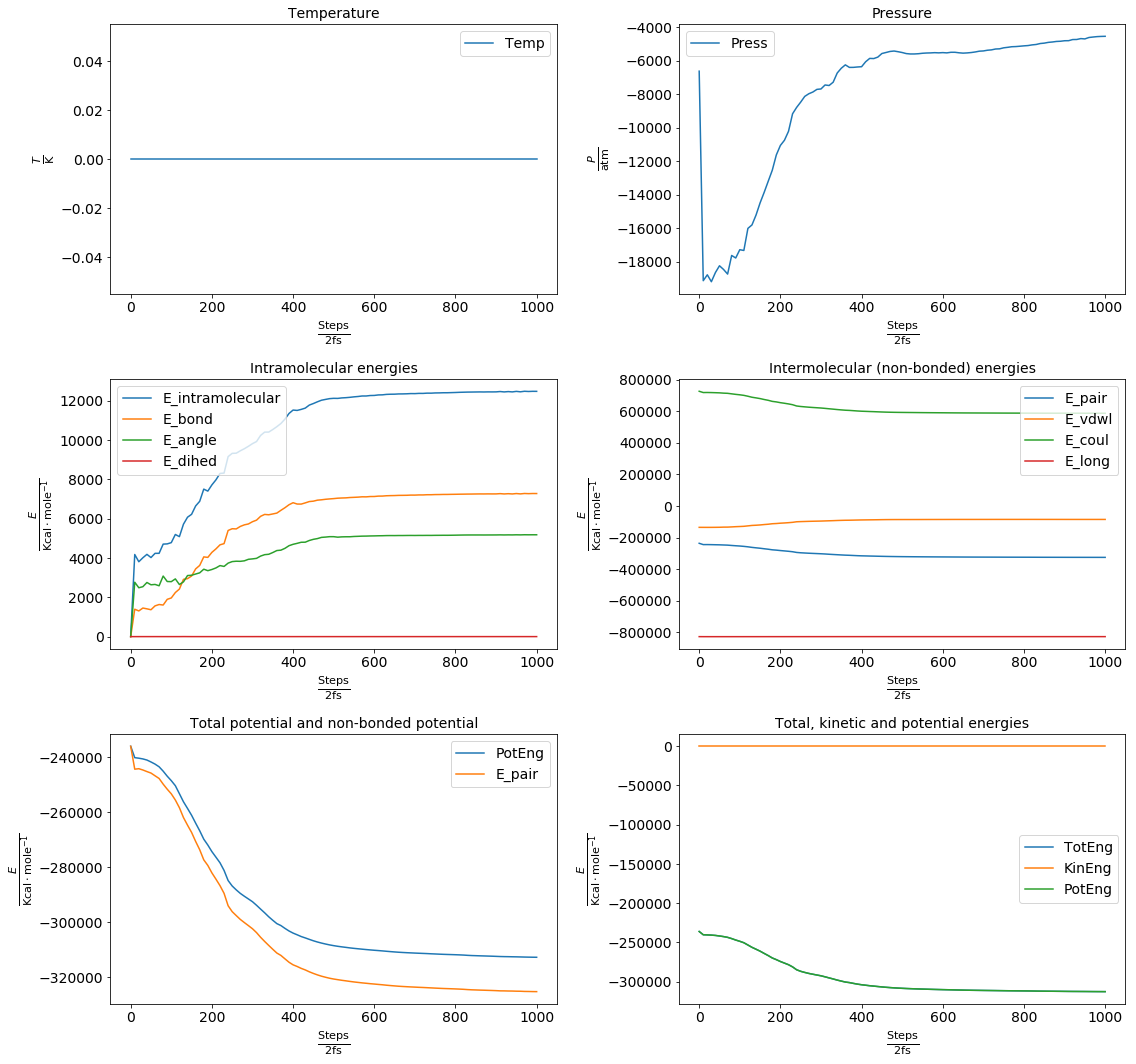

In [35]:
makeThermoPlotsFromDataFrame(minimization_thermo_pd);

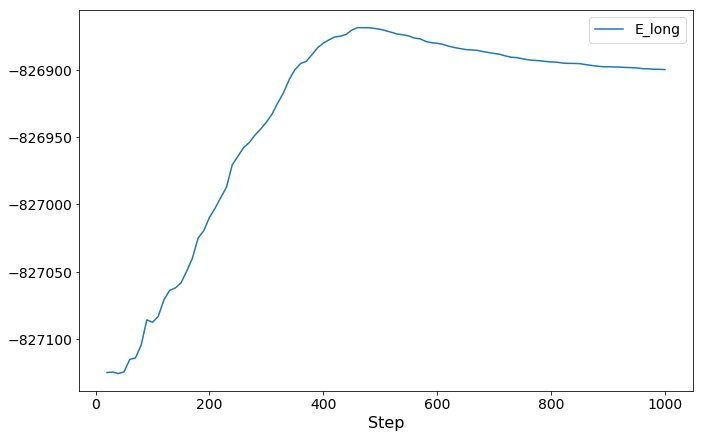

In [36]:
minimization_thermo_pd[["E_long"]][2:].plot()

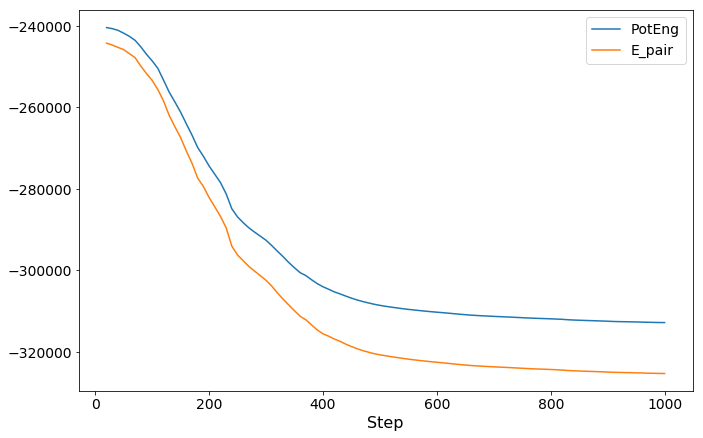

In [37]:
# The total energy decreases, but intramolecular energy increases during minimization:
minimization_thermo_pd[["PotEng","E_pair"]][2:].plot()

In [38]:
# double-check: total potential energy of system minus non-bonded energy (LJ & Coulomb) 
# should correspond to intramolecular energy:
intramolecularEnergyValidation = minimization_thermo_pd["PotEng"] - minimization_thermo_pd["E_pair"]

In [39]:
intramolecularEnergyValidationDiff = (intramolecularEnergyValidation - minimization_thermo_pd["E_intramolecular"])

In [40]:
intramolecularEnergyValidationDiff.max()

0.0086448999954882311

In [41]:
intramolecularEnergyValidationDiff.abs().max() / intramolecularEnergyValidation.min()

0.00042295074556040287

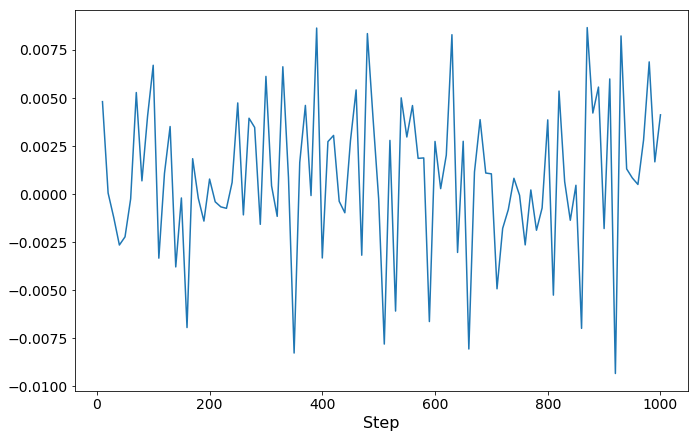

In [42]:
(intramolecularEnergyValidation - minimization_thermo_pd["E_intramolecular"])[1:].plot()
# obviously "equal" (up to a tiny fraction)

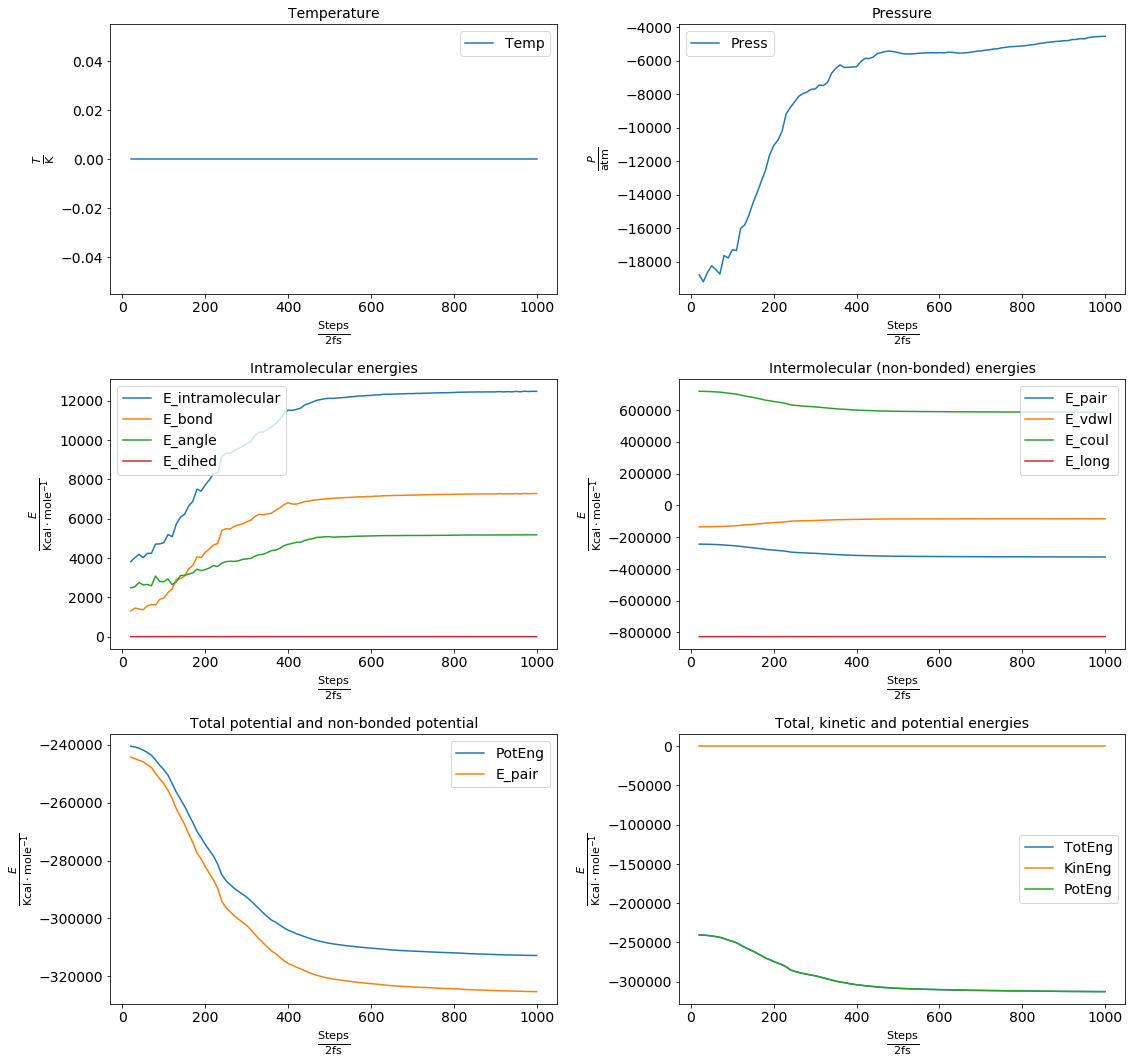

In [43]:
# descent to steep t the first few steps, excluded
makeThermoPlotsFromDataFrame(minimization_thermo_pd.iloc[2:].copy());

### 2.2. NVT equilibration

In [44]:
%ls *nvtEquilibration.log

1_CTAB_on_AU_111_21x12x2_02_nvtEquilibration.log


In [45]:
!./extract_thermo.sh *nvtEquilibration.log 02_nvtEquilibration_thermo.out

In [46]:
nvtEquilibration_thermo_file = absolute_prefix + os.sep + '02_nvtEquilibration_thermo.out'

In [47]:
nvtEquilibration_thermo_pd = pd.read_csv(nvtEquilibration_thermo_file,delim_whitespace=True)

In [48]:
nvtEquilibration_thermo_pd.set_index("Step",inplace=True)

In [49]:
nvtEquilibration_thermo_pd

TotEng     KinEng     PotEng       Temp       Press   Enthalpy  \
Step                                                                      
0    -304738.15  20514.661 -325252.81  205.55055 -2474.80280 -323756.51   
10   -279831.73  11162.020 -290993.75  111.83998  2250.85310 -262534.37   
20   -279064.05  11631.489 -290695.54  116.54392  1881.63400 -264604.07   
30   -277768.42  11501.888 -289270.31  115.24536   609.92585 -273081.26   
40   -275800.32  12394.953 -288195.28  124.19360  -259.51512 -277794.64   
50   -273052.86  13738.003 -286790.87  137.65054 -1104.41640 -281540.08   
60   -269285.54  15894.072 -285179.61  159.25368 -1466.54190 -280555.62   
70   -264376.80  18071.317 -282448.12  181.06901 -1313.55500 -274471.21   
80   -258003.60  21612.793 -279616.39  216.55349 -1071.52870 -266238.08   
90   -249843.42  26187.607 -276031.02  262.39172  -573.36962 -254249.65   
100  -239616.20  31911.330 -271527.53  319.74165   240.17124 -237770.53   
110  -227447.90  38374.539 -265822.44  384.50100  1493.22120 -215972.80   
120  -213969.88  45292.541 -259262.42  453.81725  3107.80680 -190087.01   
130  -200261.69  52068.578 -252330.27  521.71103  4623.73710 -164729.20   
140  -188055.38  58172.799 -246228.18  582.87344  5702.76300 -144230.79   
150  -179292.00  61558.695 -240850.69  616.79907  6394.97770 -130147.88   
160  -175533.60  61527.609 -237061.20  616.48760  6567.21010 -125065.90   
170  -176971.71  58262.215 -235233.92  583.76937  5984.40570 -130982.75   
180  -182523.02  53027.897 -235550.91  531.32311  4544.17570 -147601.94   
190  -190648.76  47036.808 -237685.57  471.29426  2575.48440 -170856.68   
200  -199863.76  41173.416 -241037.18  412.54489   488.41362 -196110.40   
210  -209018.92  35431.225 -244450.15  355.00990 -1298.77730 -218999.77   
220  -217463.62  30686.110 -248149.73  307.46533 -2778.90900 -238818.98   
230  -224904.95  26996.128 -251901.07  270.49284 -4039.32150 -255946.32   
240  -231325.44  24245.617 -255571.06  242.93357 -5105.82860 -270562.71   
250  -236763.17  21819.333 -258582.50  218.62296 -5733.35830 -280822.88   
260  -241289.35  20254.561 -261543.91  202.94443 -6124.98360 -288358.62   
270  -245035.97  19073.670 -264109.64  191.11227 -6285.03130 -293335.18   
280  -248052.46  18436.095 -266488.55  184.72397 -6262.88960 -296181.51   
290  -250426.63  17943.060 -268369.69  179.78391 -6035.55920 -296808.69   
...         ...        ...        ...        ...         ...        ...   
2210 -232929.74  29770.987 -262700.73  298.29608 -2040.04830 -248607.10   
2220 -232945.20  29683.012 -262628.21  297.41459 -2091.67680 -249019.32   
2230 -232957.99  29816.984 -262774.98  298.75695 -2159.46050 -249553.01   
2240 -232969.97  29654.659 -262624.63  297.13050 -2006.46720 -248389.27   
2250 -232980.63  29716.228 -262696.86  297.74741 -2011.87990 -248441.53   
2260 -232990.85  29804.408 -262795.26  298.63094 -1977.47610 -248187.36   
2270 -232997.46  29540.819 -262538.28  295.98986 -1917.37970 -247732.14   
2280 -233000.00  29801.366 -262801.37  298.60046 -1997.94370 -248353.80   
2290 -233006.13  29885.829 -262891.96  299.44676 -1984.36060 -248255.54   
2300 -233021.15  29683.270 -262704.42  297.41718 -1850.01620 -247238.15   
2310 -233032.74  29776.704 -262809.45  298.35336 -1820.87370 -247025.79   
2320 -233035.62  29681.848 -262717.47  297.40293 -1776.38710 -246686.80   
2330 -233028.14  29568.722 -262596.86  296.26944 -1726.25580 -246294.07   
2340 -233011.88  29542.094 -262553.97  296.00263 -1708.46100 -246141.06   
2350 -232982.76  29698.042 -262680.80  297.56518 -1727.68580 -246259.68   
2360 -232945.16  29767.967 -262713.13  298.26581 -1754.18810 -246425.75   
2370 -232906.59  29700.734 -262607.32  297.59217 -1657.40140 -245643.39   
2380 -232864.83  29800.327 -262665.16  298.59005 -1697.67810 -245911.15   
2390 -232823.31  29916.957 -262740.27  299.75865 -1783.72000 -246530.84   
2400 -232790.28  29653.441 -262443.72  297.11830 -1695.48020 -245819.70   
2410 -232761.23  29887.897 -262649

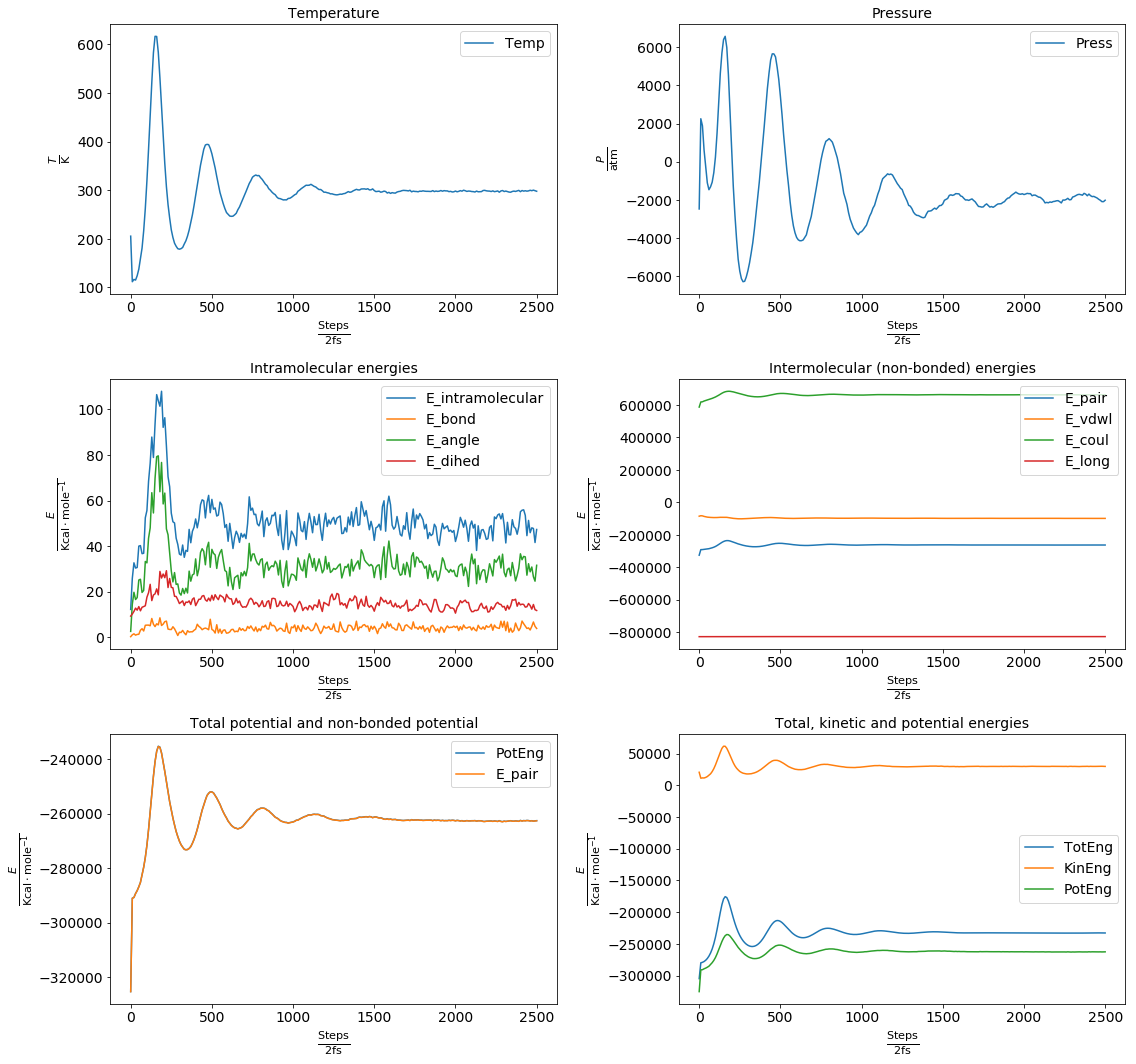

In [50]:
makeThermoPlotsFromDataFrame(nvtEquilibration_thermo_pd);

### 2.3. NPT equilibration

In [51]:
%ls *nptEquilibration.log

1_CTAB_on_AU_111_21x12x2_03_nptEquilibration.log


In [52]:
!./extract_thermo.sh *nptEquilibration.log 03_nptEquilibration_thermo.out

In [53]:
nptEquilibration_thermo_file = absolute_prefix + os.sep + '03_nptEquilibration_thermo.out'

In [54]:
nptEquilibration_thermo_pd = pd.read_csv(nptEquilibration_thermo_file,delim_whitespace=True)

In [55]:
nptEquilibration_thermo_pd.set_index("Step",inplace=True)

In [56]:
nptEquilibration_thermo_pd

TotEng     KinEng     PotEng       Temp        Press   Enthalpy  \
Step                                                                       
2500 -232800.93  29736.988 -262537.91  297.95541 -2017.512900 -248305.11   
2510 -232788.84  30151.629 -262940.47  302.10999   478.839710 -229154.13   
2520 -232929.33  30130.059 -263059.39  301.89387   -31.103970 -233165.72   
2530 -232961.53  30296.780 -263258.31  303.56436  -128.161750 -233934.93   
2540 -233088.38  30022.660 -263111.04  300.81776   -82.651712 -233715.29   
2550 -233242.94  30129.167 -263372.11  301.88492   -98.191319 -233986.92   
2560 -233419.42  29906.697 -263326.12  299.65584  -116.263720 -234299.33   
2570 -233615.24  29895.497 -263510.74  299.54362  -112.472240 -234465.20   
2580 -233835.61  29831.888 -263667.49  298.90628  -120.282170 -234743.25   
2590 -234065.00  29577.643 -263642.64  296.35883   -60.242587 -234519.02   
2600 -234271.21  29610.041 -263881.25  296.68345  -146.837810 -235376.77   
2610 -234476.98  29746.535 -264223.52  298.05107   -68.334176 -234990.72   
2620 -234685.54  29519.757 -264205.30  295.77883   -58.216940 -235122.87   
2630 -234860.78  29383.410 -264244.19  294.41268   -86.200294 -235507.82   
2640 -235006.14  29498.838 -264504.98  295.56923  -140.702010 -236060.93   
2650 -235149.18  29525.697 -264674.87  295.83834   -76.654711 -235722.97   
2660 -235272.96  29525.093 -264798.06  295.83230   -95.161638 -235984.51   
2670 -235382.75  29469.142 -264851.89  295.27168   -58.580913 -235820.36   
2680 -235460.40  29526.458 -264986.85  295.84597  -106.170690 -236252.78   
2690 -235530.75  29414.143 -264944.90  294.72061   -31.921839 -235768.72   
2700 -235575.17  29578.288 -265153.46  296.36529  -133.024000 -236566.11   
2710 -235603.76  29547.700 -265151.46  296.05881   -40.206258 -235902.87   
2720 -235621.75  29787.777 -265409.53  298.46431  -143.651110 -236689.47   
2730 -235644.74  29625.649 -265270.39  296.83984   -16.058425 -235763.95   
2740 -235655.35  29614.446 -265269.79  296.72758   -39.218895 -235946.36   
2750 -235650.01  29705.856 -265355.87  297.64348   -72.376449 -236186.77   
2760 -235643.04  29677.872 -265320.91  297.36309   -17.777380 -235774.79   
2770 -235631.53  29836.146 -265467.68  298.94895   -41.425980 -235938.36   
2780 -235640.45  29801.776 -265442.22  298.60457    20.311982 -235490.04   
2790 -235627.95  29544.085 -265172.03  296.02258   -34.916616 -235886.50   
...         ...        ...        ...        ...          ...        ...   
3290 -235589.92  29611.161 -265201.08  296.69467     5.436973 -235550.27   
3300 -235573.38  29832.666 -265406.05  298.91408    34.375160 -235322.85   
3310 -235535.44  29982.165 -265517.61  300.41201   -12.359292 -235625.53   
3320 -235539.14  29732.976 -265272.11  297.91522    31.149237 -235311.97   
3330 -235480.69  29928.746 -265409.44  299.87678  -119.564150 -236352.92   
3340 -235486.10  29941.483 -265427.59  300.00440    80.214420 -234901.78   
3350 -235495.30  29905.798 -265401.10  299.64684   -45.502585 -235826.82   
3360 -235516.06  29857.618 -265373.68  299.16409    30.674366 -235292.61   
3370 -235539.38  29743.286 -265282.67  298.01852    -0.524014 -235543.20   
3380 -235576.47  29759.456 -265335.93  298.18054     9.126506 -235509.95   
3390 -235602.21  29736.859 -265339.07  297.95413   -16.038316 -235719.13   
3400 -235642.72  29643.065 -265285.79  297.01433    30.560255 -235419.92   
3410 -235647.30  29670.075 -265317.38  297.28497   -80.209225 -236232.09   
3420 -235687.23  29733.598 -265420.83  297.92145   144.108090 -234637.59   
3430 -235707.76  29702.517 -265410.28  297.61002  -148.144960 -236788.00   
3440 -235699.11  29791.879 -265490.99  298.50540   105.400680 -234931.70   
3450 -235768.78  29927.584 -265696.36  299.86513     4.103219 -235738.90   
3460 -235786.41  29754.999 -265541.41  298.13588   -38.510864 -236066.99   
3470 -235828.74  29598.875 -265427.62  296.57156    25.247336 -235644.83   
3480 -235849.83  29629.535 -265479.36  296.87877   -36.95

In [57]:
equilibration_pd = pd.concat([nvtEquilibration_thermo_pd,nptEquilibration_thermo_pd])

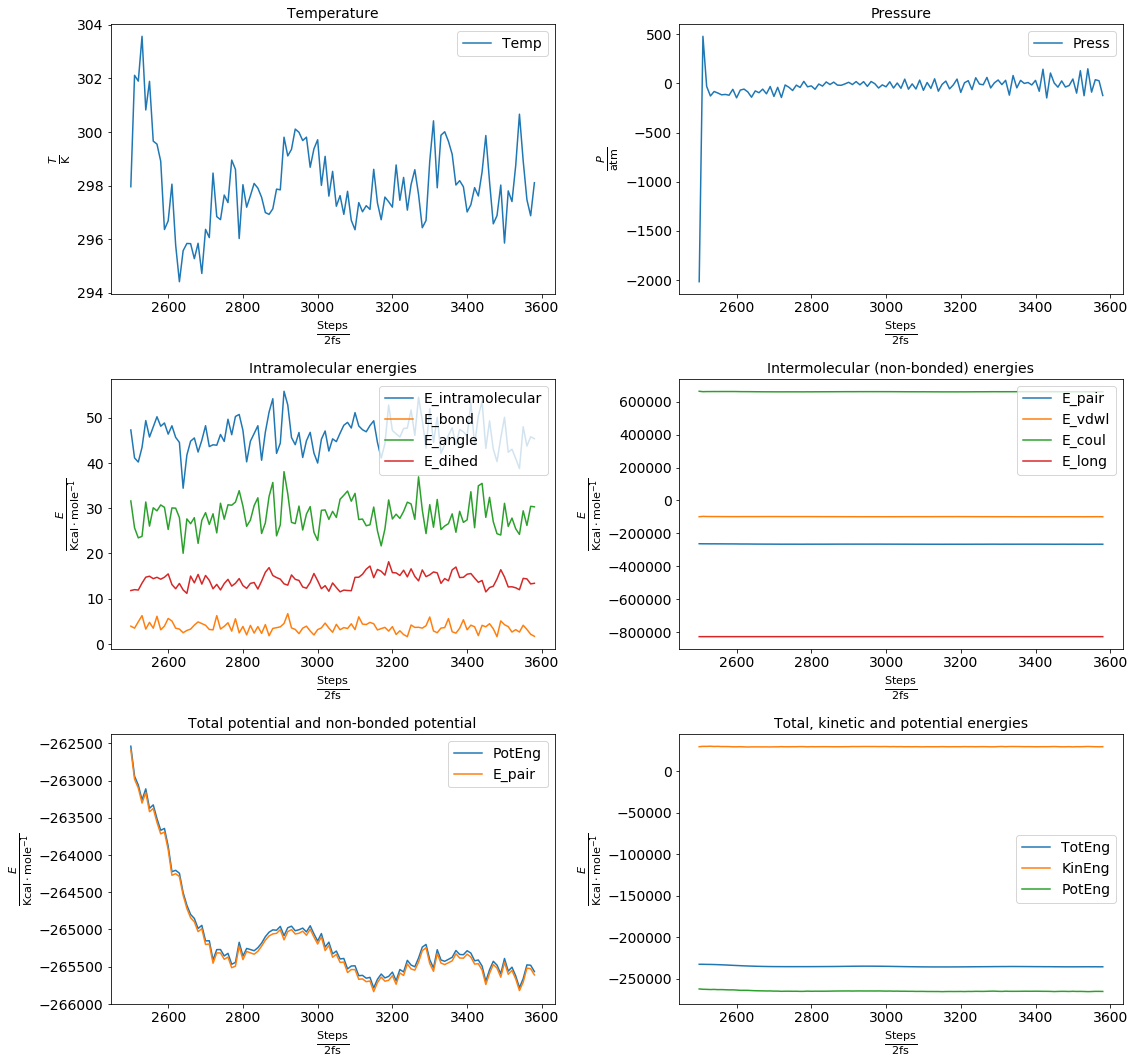

In [58]:
makeThermoPlotsFromDataFrame(nptEquilibration_thermo_pd);

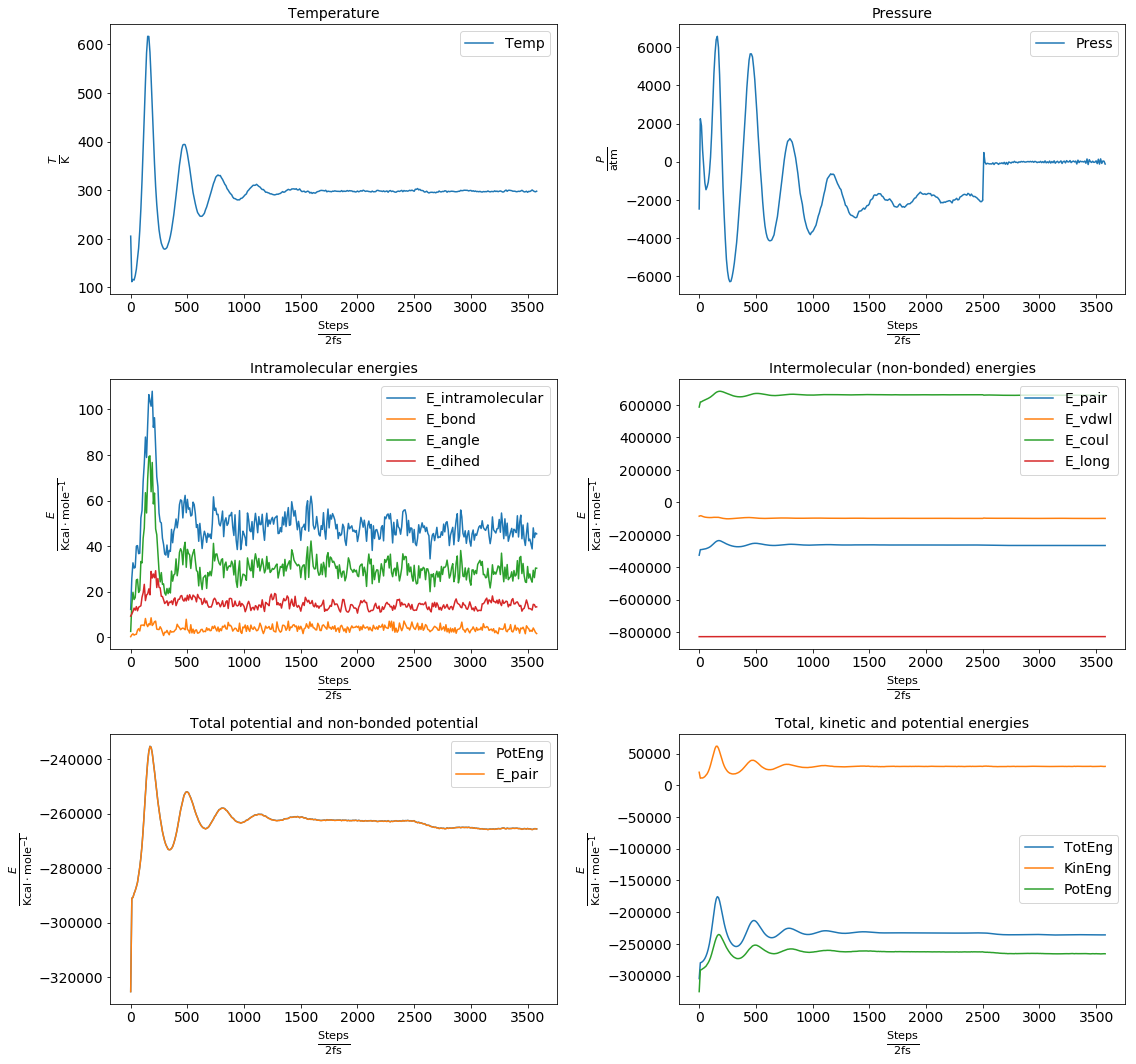

In [59]:
# show nvt and npt equilibration consecutively
makeThermoPlotsFromDataFrame(equilibration_pd);

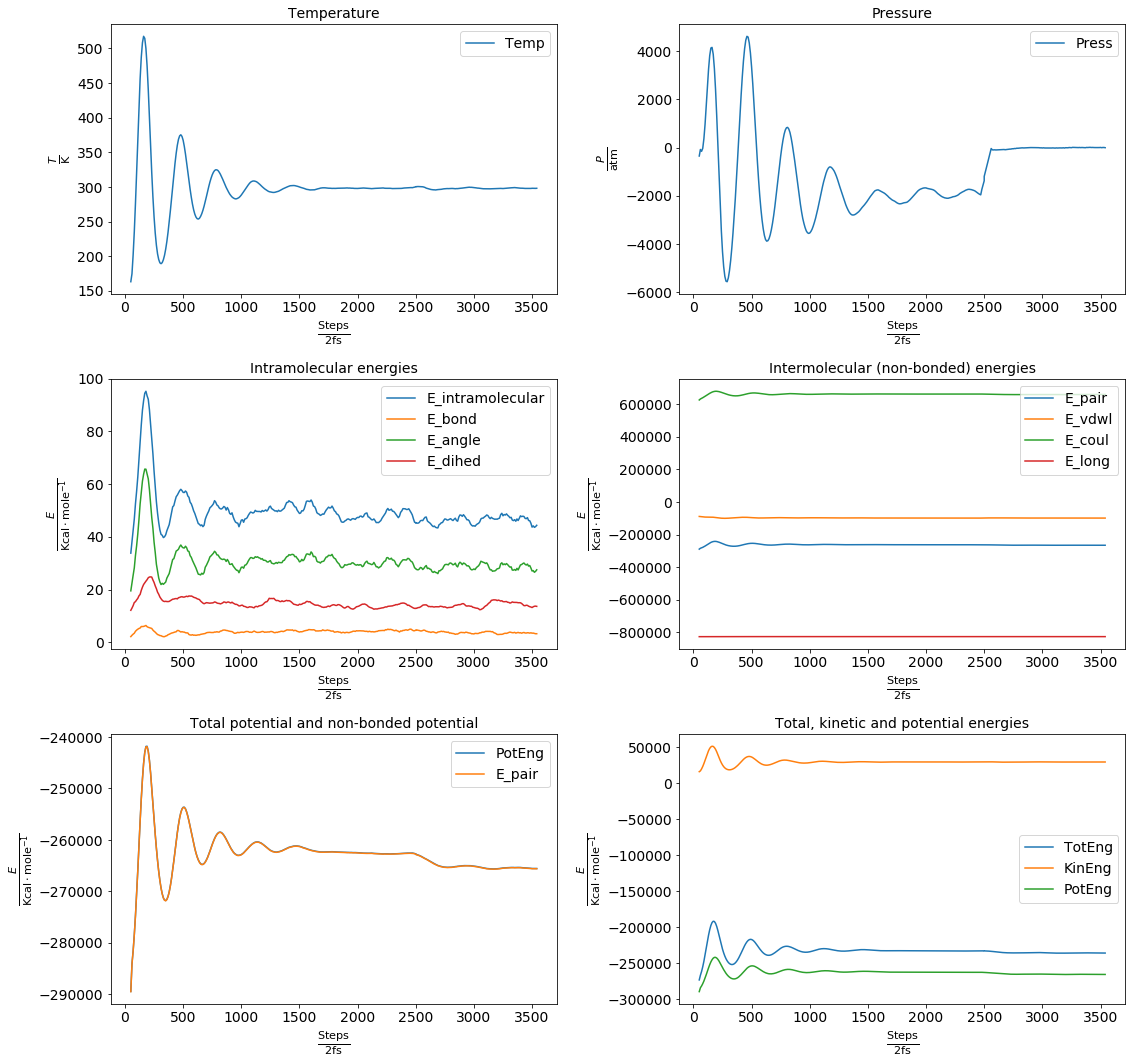

In [60]:
makeRollingAverageThermoPlotsFromDataFrame(equilibration_pd,window=10);

### 2.4. 10 ps NPT

In [ ]:
!./extract_thermo.sh *_10ps_npt_01_nptProduction.log 05_10ps_nptProduction_thermo.out

In [ ]:
nptProduction10ps_thermo_file = absolute_prefix + os.sep + '05_10ps_nptProduction_thermo.out'

In [ ]:
nptProduction10ps_thermo_pd = pd.read_csv(nptProduction10ps_thermo_file,delim_whitespace=True)

In [ ]:
nptProduction10ps_thermo_pd.set_index("Step",inplace=True)

In [ ]:
nptProduction10ps_thermo_pd

In [ ]:
makeThermoPlotsFromDataFrame(nptProduction10ps_thermo_pd);

In [ ]:
makeRollingAverageThermoPlotsFromDataFrame(nptProduction10ps_thermo_pd,window=10);

### 2.5. 100 ps NPT

In [ ]:
!./extract_thermo.sh *_100ps_npt_01_nptProduction.log 05_100ps_nptProduction_thermo.out

In [ ]:
nptProduction_100ps_thermo_file = absolute_prefix + os.sep + '05_100ps_nptProduction_thermo.out'
nptProduction_100ps_thermo_pd = pd.read_csv(nptProduction_100ps_thermo_file,delim_whitespace=True)
nptProduction_100ps_thermo_pd.set_index("Step",inplace=True)

In [ ]:
makeThermoPlotsFromDataFrame(nptProduction_100ps_thermo_pd.iloc[::20].copy()); # only every 20th data point

### 2.6. 1 ns NPT

In [60]:
%ls *_1ns_npt_with_restarts_01_nptProduction.log

1_SDS_on_AU_111_6x4x1_1ns_npt_with_restarts_01_nptProduction.log


In [61]:
!./extract_thermo.sh *_1ns_npt_with_restarts_01_nptProduction.log 05_1ns_nptProduction_thermo.out

In [62]:
nptProduction_1ns_thermo_file = absolute_prefix + os.sep + '05_1ns_nptProduction_thermo.out'
nptProduction_1ns_thermo_pd = pd.read_csv(nptProduction_1ns_thermo_file,delim_whitespace=True)
nptProduction_1ns_thermo_pd.set_index("Step",inplace=True)

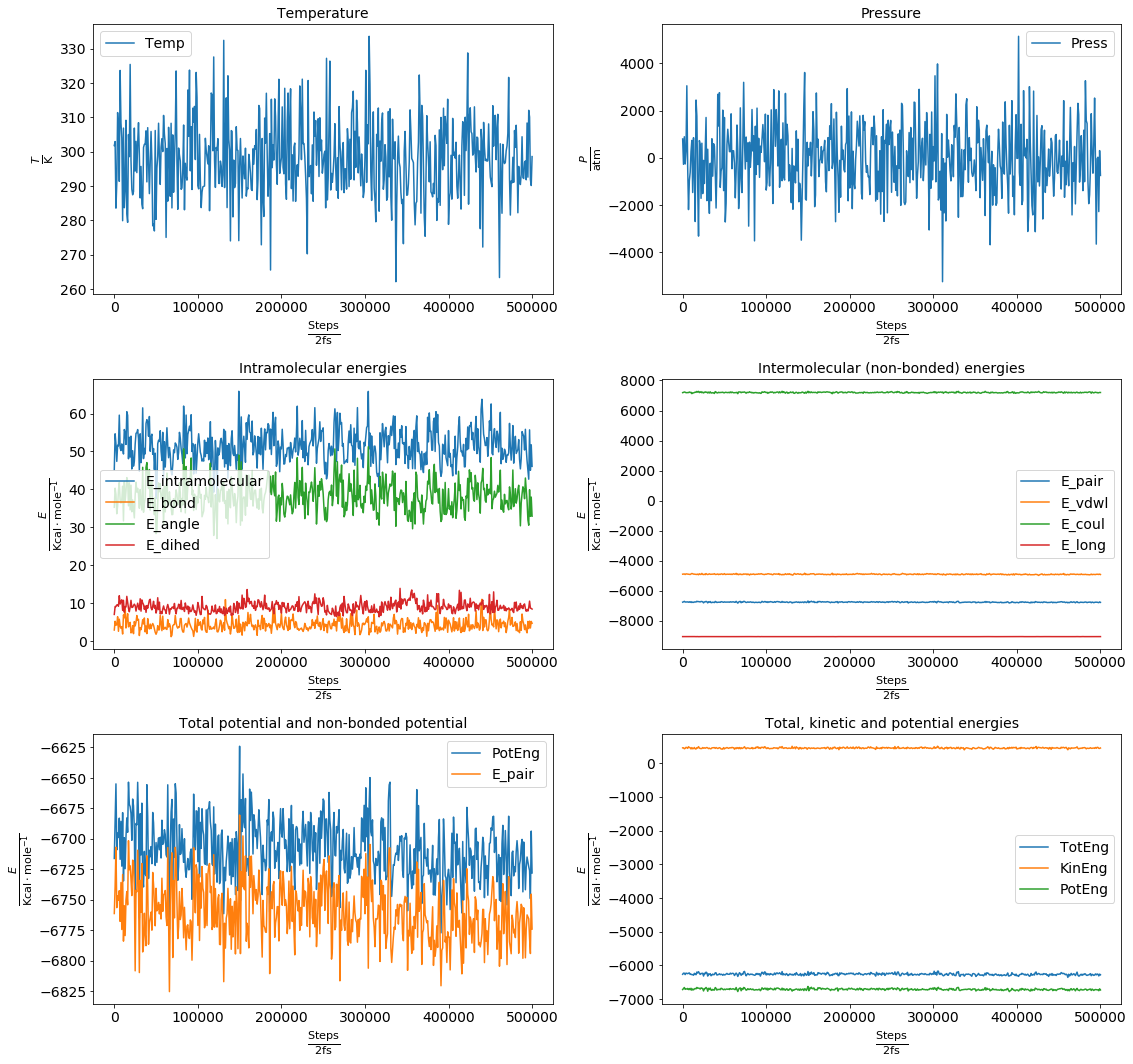

In [63]:
makeThermoPlotsFromDataFrame(nptProduction_1ns_thermo_pd.iloc[::100].copy()); # only every 100th data point

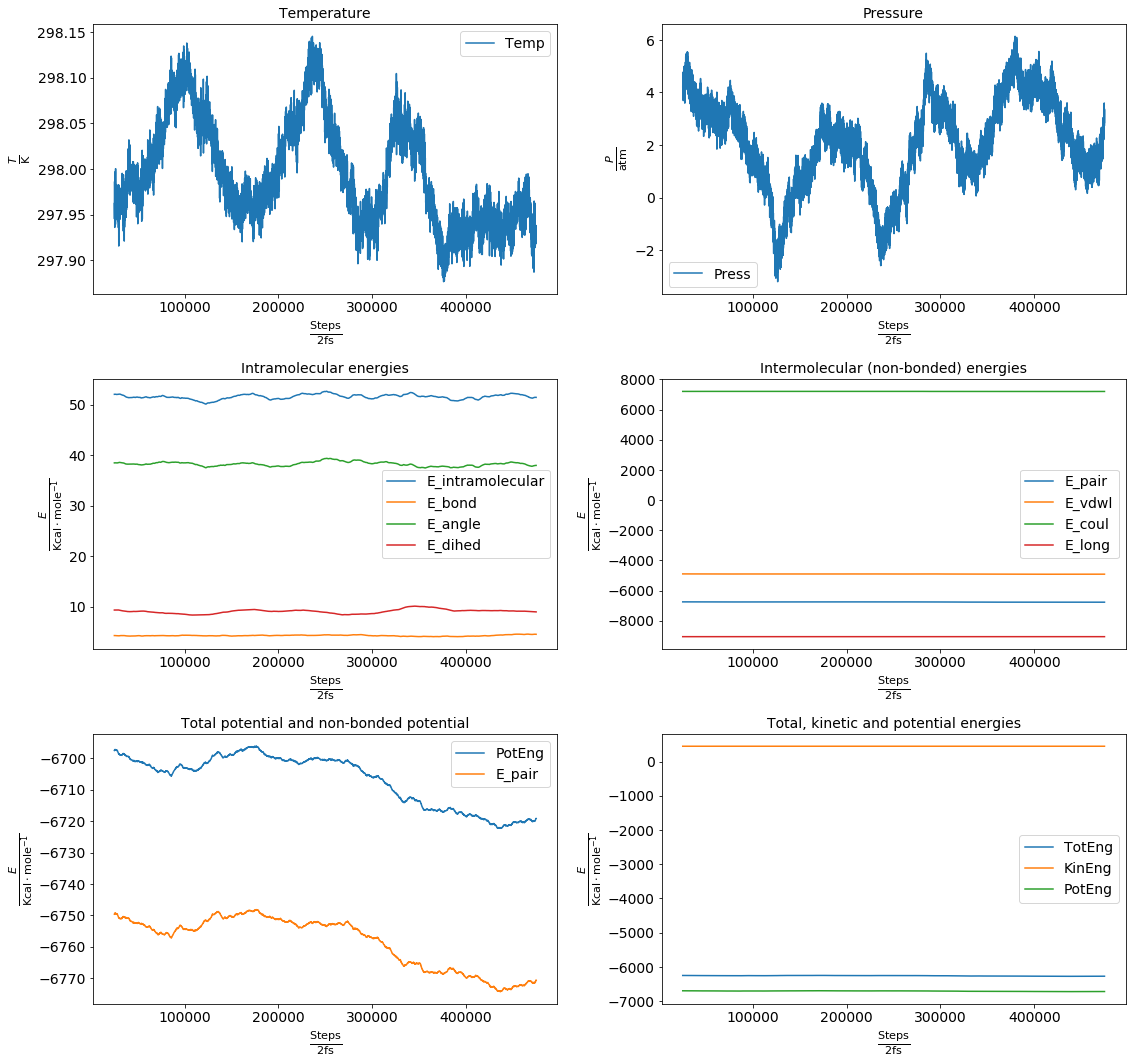

In [64]:
makeRollingAverageThermoPlotsFromDataFrame(nptProduction_1ns_thermo_pd,window=5000);

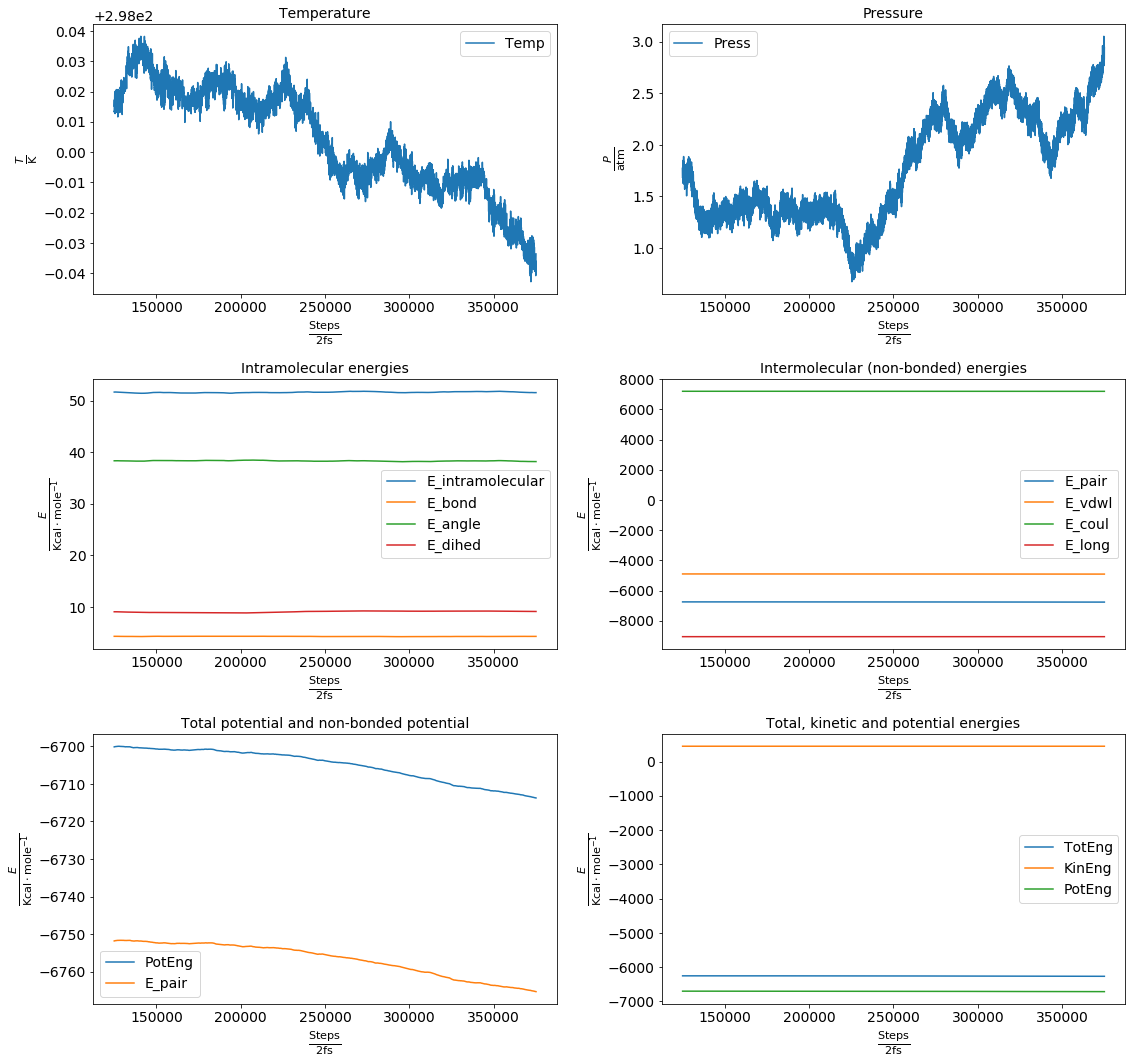

In [65]:
makeRollingAverageThermoPlotsFromDataFrame(nptProduction_1ns_thermo_pd,window=25000);

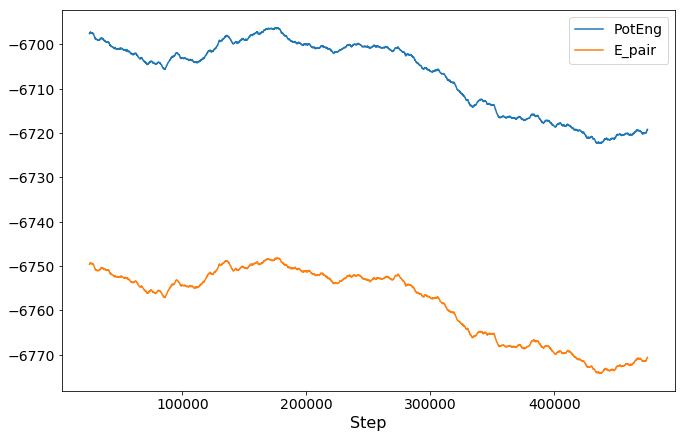

In [66]:
nptProduction_1ns_thermo_pd[["PotEng","E_pair"]].rolling(window=5000,center=True).mean().plot()

### 2.7. 1 ns NVE

In [68]:
%ls *_1ns_nve_with_restarts_01_nveProduction.log

1_SDS_on_AU_111_6x4x1_1ns_nve_with_restarts_01_nveProduction.log


In [69]:
!./extract_thermo.sh *_1ns_nve_with_restarts_01_nveProduction.log 05_1ns_nveProduction_thermo.out

In [71]:
nveProduction_1ns_thermo_file = absolute_prefix + os.sep + '05_1ns_nveProduction_thermo.out'
nveProduction_1ns_thermo_pd = pd.read_csv(nveProduction_1ns_thermo_file,delim_whitespace=True)
nveProduction_1ns_thermo_pd.set_index("Step",inplace=True)

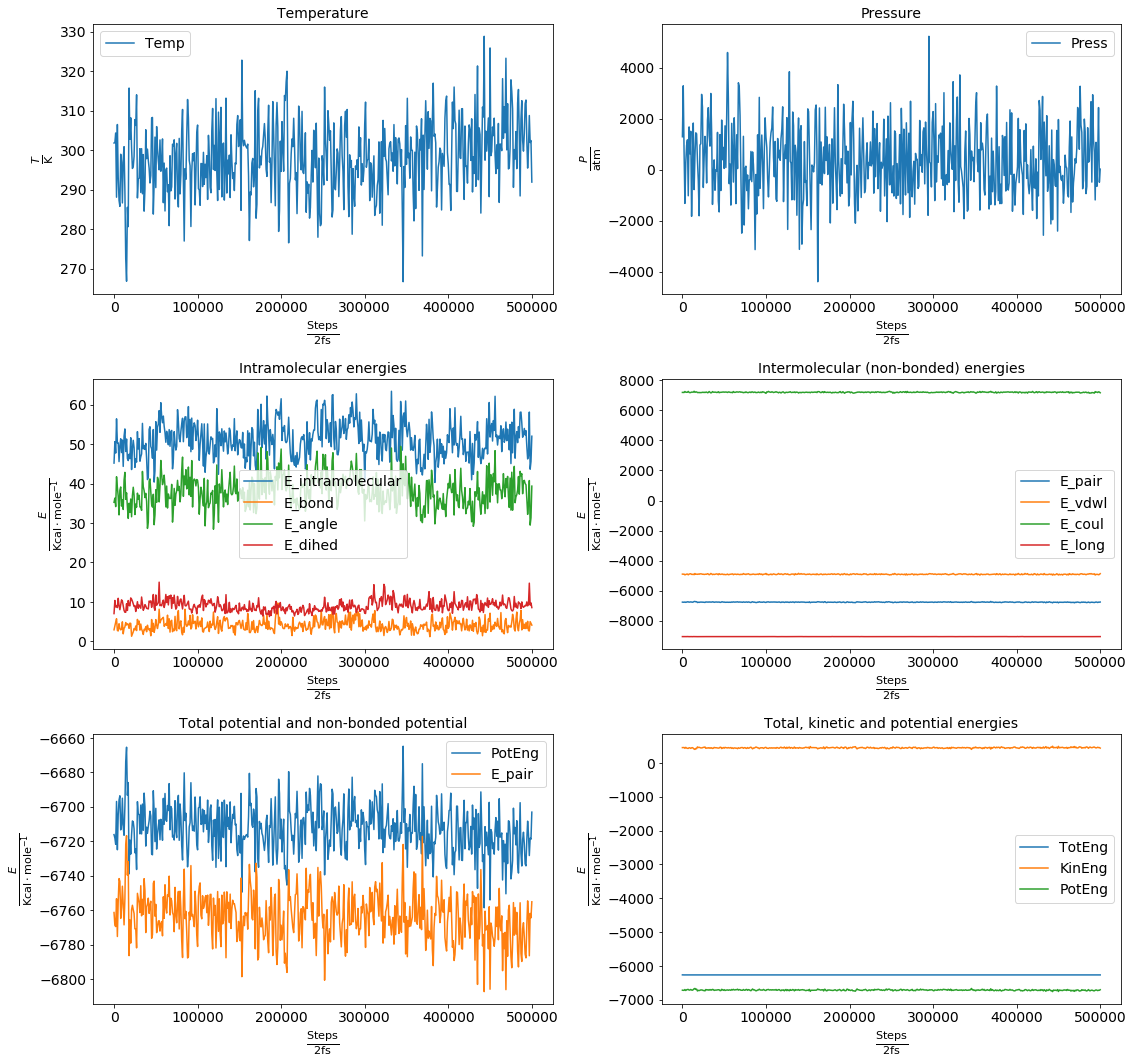

In [72]:
makeThermoPlotsFromDataFrame(nveProduction_1ns_thermo_pd.iloc[::100].copy()); # only every 100th data point

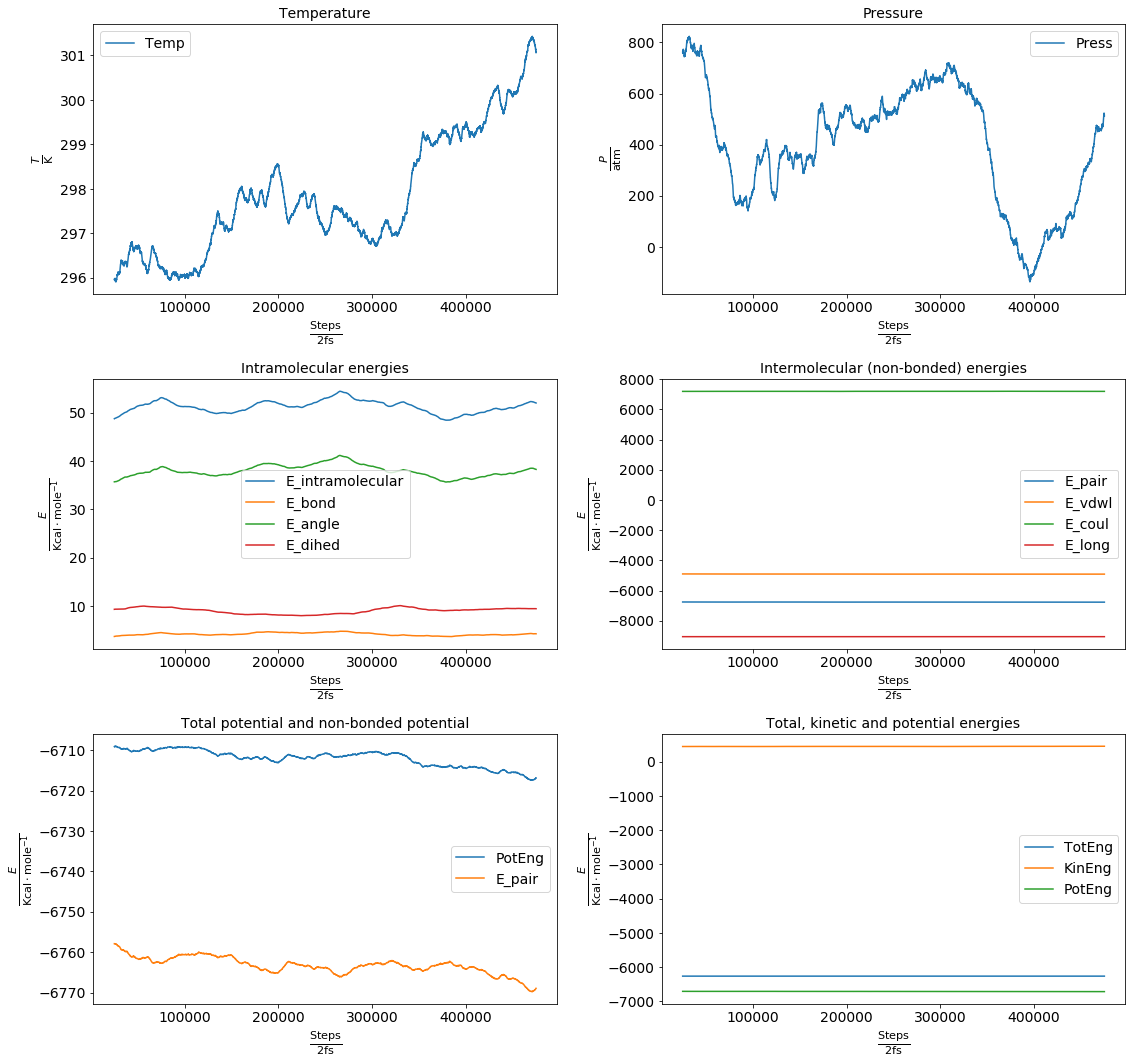

In [73]:
makeRollingAverageThermoPlotsFromDataFrame(nveProduction_1ns_thermo_pd,window=5000);

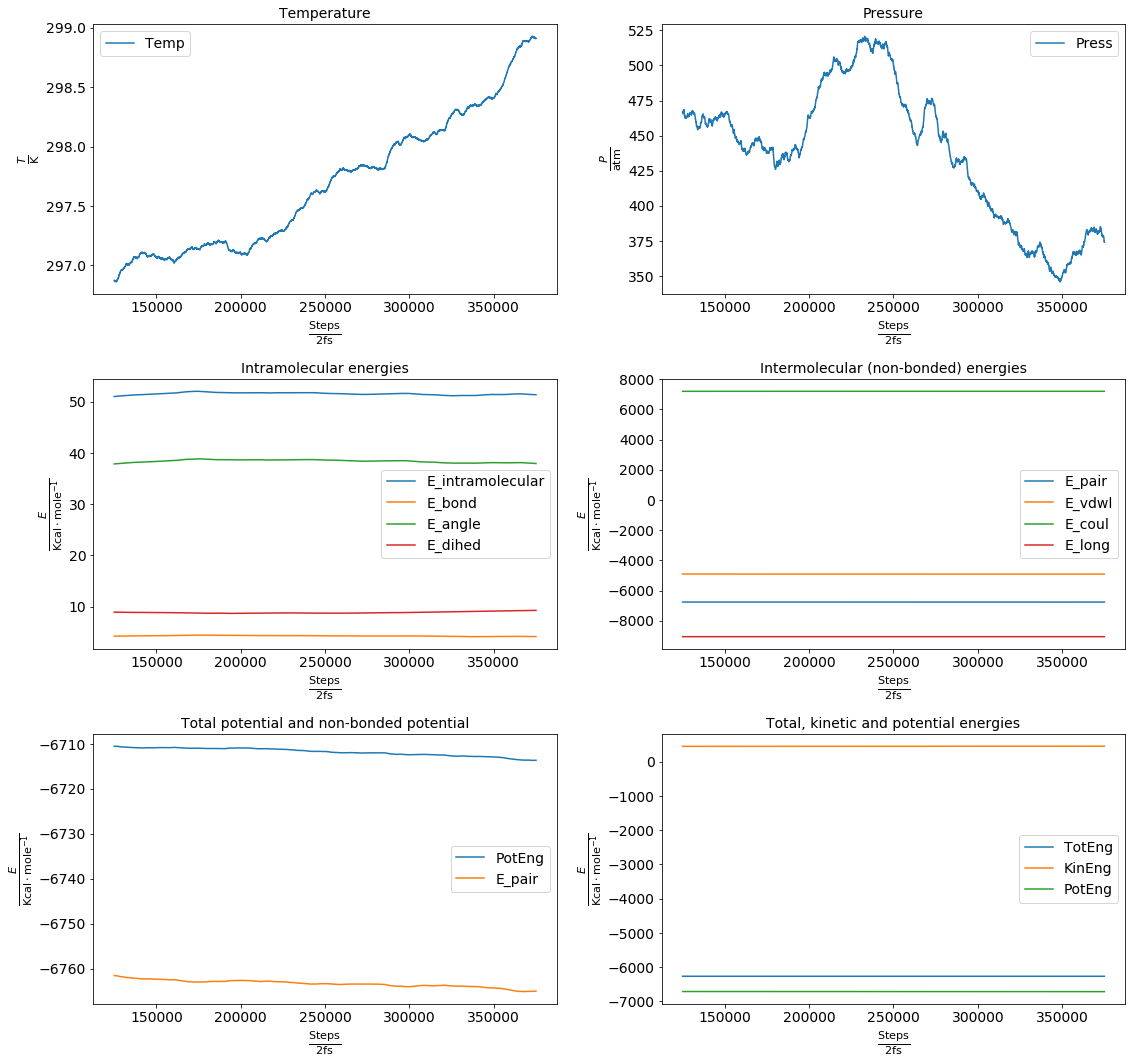

In [74]:
makeRollingAverageThermoPlotsFromDataFrame(nveProduction_1ns_thermo_pd,window=25000);

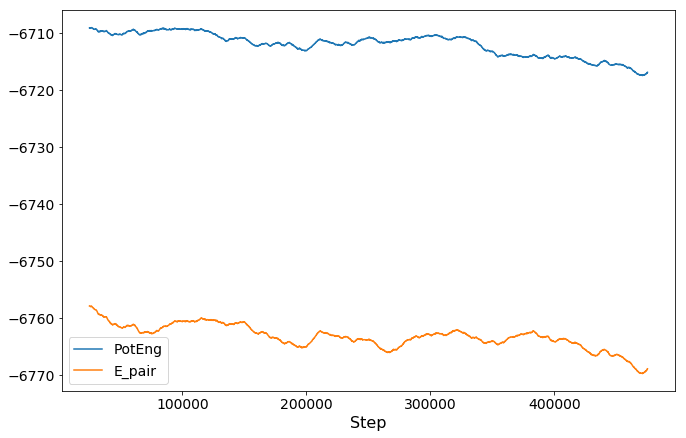

In [75]:
nveProduction_1ns_thermo_pd[["PotEng","E_pair"]].rolling(window=5000,center=True).mean().plot()

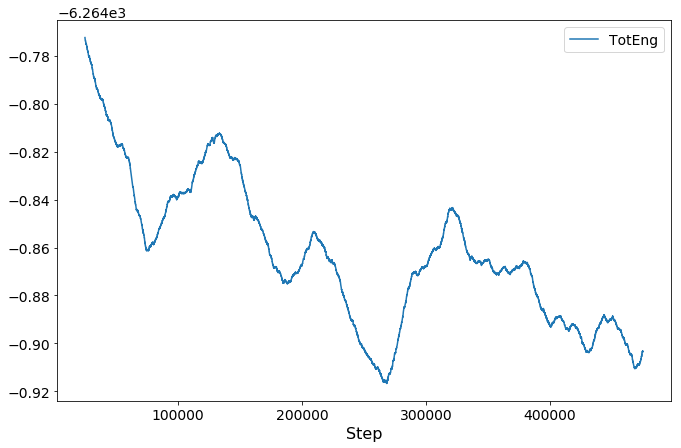

In [324]:
nveProduction_1ns_thermo_pd[["TotEng"]].rolling(window=5000,center=True).mean().plot()

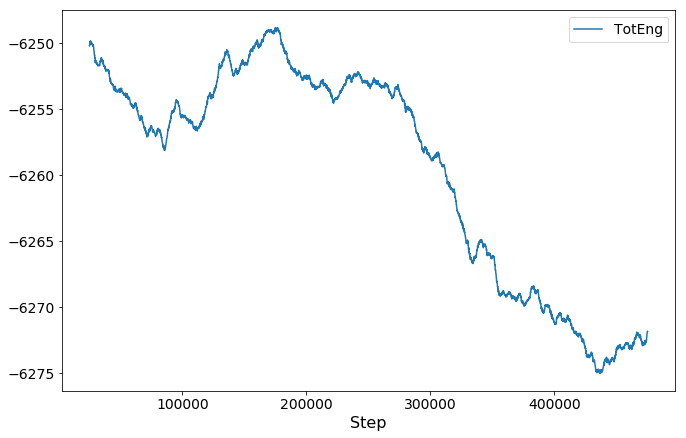

In [323]:
nptProduction_1ns_thermo_pd[["TotEng"]].rolling(window=5000,center=True).mean().plot()

## 3. Trajectory visualization with ASE and ParmEd

In [61]:
%ls *.lammps

1_CTAB_on_AU_111_21x12x2_minimized.lammps        log.lammps
1_CTAB_on_AU_111_21x12x2_nvtEquilibrated.lammps


In [62]:
%ls *.dump

1_CTAB_on_AU_111_21x12x2_nptEquilibration.dump
1_CTAB_on_AU_111_21x12x2_nvtEquilibration.dump


In [101]:
# File names
prefix = '1_CTAB_on_AU_111_21x12x2_'

pdb_file_initial_config = absolute_prefix + os.sep + prefix + 'psfgen_ctrl.pdb'

lmp_files = { 'initial':         prefix + 'psfgen_CLA2BR.data',
              'minimized':       prefix + 'minimized.lammps',
              'nvtEquilibrated': prefix + 'nvtEquilibrated.lammps',
              #'nptEquilibrated': prefix + 'nptEquilibrated.lammps',
              #'npt10ps':         prefix + '10ps_npt_final_config.lammps',
              #'npt100ps':        prefix + '100ps_npt_final_config.lammps',
              #'npt1ns':          prefix + '1ns_npt_with_restarts_final_config.lammps',
              #'nve1ns':          prefix + '1ns_nve_with_restarts_final_config.lammps'
            }

lmp_dumps = { 
              'nvtEquilibration': prefix + 'nvtEquilibration.dump',
              #'nptEquilibration': prefix + 'nptEquilibration.dump',
              #'npt10ps':          prefix + '10ps_npt_nptProduction.dump',
              #'npt100ps':         prefix + '100ps_npt_nptProduction.dump',
              #'npt1ns':           prefix + '1ns_npt_with_restarts_nptProduction.dump',
              #'nve1ns':           prefix + '1ns_nve_with_restarts_nveProduction.dump' 
             }

In [66]:
# construct a dictionary-like atom type-> atom number array
t2n, t2n_array = inferTypes2NumbersFromPdbAndLmp(pdb_file_initial_config, lmp_files['initial'])

PDB contains following residue types ['AUM' 'CTA' 'HOH' 'ION']
System contains 11 atom types.


In [67]:
t2n

{1: 1, 2: 1, 3: 1, 4: 6, 5: 6, 6: 6, 7: 7, 8: 79, 9: 1, 10: 8, 11: 6}

In [ ]:
t2n

In [68]:
t2n_array

array([0, 1, 1, ..., 1, 8, 6], dtype=uint64)

In [74]:
np.array(ase.data.chemical_symbols)[t2n_array] # double-check against LAMMPS data file

array(['X', 'H', 'H', 'H', 'C', 'C', 'C', 'N', 'Au', 'H', 'O', 'C'],
      dtype='<U2')

In [89]:
# correction for manually added Bromide
np.where(np.array(ase.data.chemical_symbols) == 'Br')[0][0]

35

In [87]:
t2n[11] = np.where(np.array(ase.data.chemical_symbols) == 'Br')[0][0]

In [88]:
t2n

{1: 1, 2: 1, 3: 1, 4: 6, 5: 6, 6: 6, 7: 7, 8: 79, 9: 1, 10: 8, 11: 35}

In [92]:
t2n_array[11] = t2n[11]

### 3.1. Initial configuration from .pdb

In [93]:
# create atom selections for later post-processing:
struct_pdb_pmd     = pmd.read_PDB(pdb_file_initial_config)
water              = [ a for a in struct_pdb_pmd.atoms if a.residue.name == 'HOH' ] # water
water_indices      = [ a.number - 1 for a in water ] # to remove water atoms later
surface            = [ a for a in struct_pdb_pmd.atoms if a.residue.name == 'AUM' ] # gold surface
surface_indices    = [ a.number - 1 for a in surface ] 
surfactant         = [ a for a in struct_pdb_pmd.atoms if a.residue.name == 'CTA' ]
surfactant_indices = [ a.number - 1 for a in surfactant ] 
ions               = [ a for a in struct_pdb_pmd.atoms if a.residue.name == 'ION' ] # sodium counterions
ion_indices        = [ a.number - 1 for a in ions ] 

In [94]:
surface_indices[0] # double check index begins at 0

0

In [95]:
len(surfactant_indices)

62

In [96]:
ions

[<Atom CLA [16556]; In ION 7515>]

In [97]:
ions[0].atomic_number # wrong: inferred S (sulfur)

6

In [98]:
nv.show_parmed(struct_pdb_pmd)

NGLWidget()

### 3.2. LAMMPS data files

In [142]:
# read frames of interest
lmp_frames = {}
for k,f in lmp_files.items():
    lmp_frames[k] = read(lmp_files[k],format='lammps-data')
    lmp_frames[k].set_atomic_numbers(
        t2n_array[lmp_frames[k].get_atomic_numbers() ] )

In [143]:
lmp_frames['minimized']

Atoms(symbols='C19H30452Au3024BrNO15205', pbc=True, cell=[64.107506, 64.107506, 128.215012], angles=..., bonds=..., id=..., masses=..., mol-id=..., momenta=..., travel=..., type=...)

In [104]:
lmp_views = []
for k, f in lmp_frames.items():
    lmp_views.append( nv.show_ase(f) )
    lmp_views[-1]._set_sync_camera()
    lmp_views[-1]._remote_call("setSize", target="Widget", args=["250px", "250px"])
    lmp_views[-1].center()
    lmp_views[-1].render_image()

In [105]:
vbox = ipywidgets.VBox(lmp_views)

In [106]:
vbox

VBox(children=(NGLWidget(), NGLWidget(), NGLWidget()))

In [163]:
# frames stripped of all oxygen & hydrogen:
# apparently, order of atoms in dump trajectories is fixed, but 
# in LAMMPS data files not, hence the indexing does not work based upon previously derived sets
lmp_naked_frames = {}
for k,f in lmp_frames.items():
    #lmp_naked_frames[k] = []
    #or f in lmp_frames[k]:
    #g = f.copy()
    g = f[ (np.array(f.get_chemical_symbols()) != 'O') & (np.array(f.get_chemical_symbols()) != 'H')]
    #del g[water_indices]
    lmp_naked_frames[k] = g.copy()

In [165]:
lmp_naked_frames["nvtEquilibrated"]

Atoms(symbols='C19Au3024BrN', pbc=True, cell=[64.107506, 64.107506, 128.215012], angles=..., bonds=..., id=..., masses=..., mol-id=..., momenta=..., travel=..., type=...)

In [166]:
lmp_frames["nvtEquilibrated"]

Atoms(symbols='C19H30452Au3024BrNO15205', pbc=True, cell=[64.107506, 64.107506, 128.215012], angles=..., bonds=..., id=..., masses=..., mol-id=..., momenta=..., travel=..., type=...)

In [167]:
lmp_views = []
for k, f in lmp_naked_frames.items():
    lmp_views.append( nv.show_ase(f) )
    lmp_views[-1]._set_sync_camera()
    lmp_views[-1]._remote_call("setSize", target="Widget", args=["250px", "250px"])
    lmp_views[-1].center()
    lmp_views[-1].render_image()

In [168]:
vbox = ipywidgets.VBox(lmp_views)

In [169]:
vbox

VBox(children=(NGLWidget(), NGLWidget(), NGLWidget()))

### 3.3. LAMMPS trajectories

In [107]:
lmp_trajectrories = {}
for k,t in lmp_dumps.items():
    lmp_trajectrories[k] = read(t, index=':',format='lammps-dump')
    for f in lmp_trajectrories[k]:      
        f.set_atomic_numbers(
            t2n_array[f.get_atomic_numbers() ] )
        f.center()

In [108]:
%memit

peak memory: 534.31 MiB, increment: -0.31 MiB


In [109]:
len(lmp_trajectrories['nvtEquilibration'])

26

In [111]:
view(lmp_trajectrories['nvtEquilibration'], viewer='ase') # opens ASE GUI

In [99]:
#nv.show_asetraj(lmp_trajectrories['npt100ps'])

In [100]:
# Several problems with nglview:
#  1) does not display or infer bonding for ASE trajectory
#  2) even with displayed gui, not clear how to activate

### 3.4. LAMMPS trajectories, stripped of solvent

In [112]:
lmp_naked_trajectrories = {}
for k in lmp_trajectrories:
    lmp_naked_trajectrories[k] = []
    for f in lmp_trajectrories[k]:
        g = f.copy()
        del g[water_indices]
        lmp_naked_trajectrories[k].append(g)

In [102]:
trajectoryView = nv.show_asetraj(lmp_naked_trajectrories['npt1ns'][::100])

In [113]:
trajectoryView = nv.show_asetraj(lmp_naked_trajectrories['nvtEquilibration'][::100])

In [114]:
trajectoryView.remove_ball_and_stick()

In [115]:
trajectoryView.add_spacefill() # try a different representation sytle

In [116]:
trajectoryView

NGLWidget()

In [106]:
view(lmp_naked_trajectrories['npt1ns'], viewer='ase') # opens ASE GUI

In [118]:
view(lmp_naked_trajectrories['nvtEquilibration'], viewer='ngl') # opens ASE GUI

HBox(children=(NGLWidget(count=26), VBox(children=(Dropdown(description='Show', options=('All', 'H', 'Au', 'N', 'Br', 'C'), value='All'), FloatSlider(value=0.8, description='Ball size', max=1.5, step=0.01), IntSlider(value=0, max=25)))))

In [107]:
# Several problems with nglview:
#  1) does not display or infer bonding for ASE trajectory
#  2) even with displayed gui, not clear how to activate

### 3.5. Make a movie via .png frames and ffmpeg

In [108]:
# create a subdir from within the notebook
%mkdir png

In [298]:
traj = lmp_naked_trajectrories['npt1ns']

In [243]:
nv.show_ase(traj[200])

NGLWidget()

In [113]:
# from ~ frame 3500 to the end ~ means

In [114]:
totalFramesAvailable = 5000

In [115]:
desiredVideoDuration = 30 # s

In [116]:
framesPerSecond = 30 # s^-1

In [117]:
neededFrames = desiredVideoDuration*framesPerSecond

In [118]:
neededFrames

900

In [119]:
every_nth = np.ceil(totalFramesAvailable / neededFrames).astype(int)

In [120]:
every_nth

6

In [121]:
png_prefix = absolute_prefix + os.sep + 'png' + os.sep + 'traj_1ns'

In [313]:
f = traj[0].copy()

In [314]:
# find a desired orientation
#f.rotate('x', (-1,2,-1), rotate_cell=True)
f.rotate('-y', 'z', rotate_cell=True)

In [315]:
nv.show_ase(f)

NGLWidget()

In [316]:
cell = f.get_cell()

In [317]:
cell

array([[ 18.48465488,   0.        ,   0.        ],
       [  0.        ,   0.        , -18.48465488],
       [  0.        ,  23.10581954,   0.        ]])

In [319]:
bbox = [-5, -5, 24, 28 ]

In [318]:
# one trial
# the commented lines can be used to replicate the cell
cell = f.get_cell()
f = f.repeat((3, 1, 3))
f.set_cell(cell)
# bbox = [-5, -5, cell[0,0] + 5, cell[1,1] + 5 ]
f.center()
ase.io.write(png_prefix + '_test.png', f, show_unit_cell=True, 
                bbox=bbox)
# the bounding vox's 1st coordinate corresponds to the horizontal direction
# and ASE's x direction

Load image with

    ![title](png/traj_1ns_test.png?arg)
    
and change to some random string after the question mark in order to enforce reloading when image changed on disk ([https://github.com/jupyter/notebook/issues/1369])
![title](png/traj_1ns_test.png?fddfrtzra)

In [320]:
# make a movie
# https://wiki.fysik.dtu.dk/ase/development/making_movies.html
#for i,f in enumerate(frames_1ns_stripped[0::every_nth]):
for i,f in enumerate(traj[::every_nth]):
    f.rotate('-y', 'z', rotate_cell=True)
    cell = f.get_cell()
    f = f.repeat((3, 1, 3))
    f.set_cell(cell)
    ase.io.write(png_prefix + '_{:05d}.png'.format(i), f, show_unit_cell=True, 
                bbox=bbox)
# bbox measures chosen to exceed cell once in x direction and twice in (repeated) y direction
# externally execute
#    ffmpeg -r 30 -f image2 -i "traj_1ns_%05d.png" -vcodec libx264 -crf 25 -pix_fmt yuv420p "traj_1ns.mp4

In [252]:
# operating some bash commands from within jupyter nb
%cd png

[Errno 2] No such file or directory: 'png'
/work/ws/nemo/fr_jh1130-201708-0/jobs/lmplab/sds/201806/1_SDS_on_AU_111_6x4x1/png


In [253]:
group_ws=%env GROUP_WS

In [254]:
group_ws

'/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0'

In [ ]:
!find $group_ws -name ffmpeg

In [251]:
%pwd

'/work/ws/nemo/fr_jh1130-201708-0/jobs/lmplab/sds/201806/1_SDS_on_AU_111_6x4x1/png'

In [321]:
%%bash
source '/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/env.sh'
ffmpeg -r 30 -f image2 -i "traj_1ns_%05d.png" -vcodec libx264 -crf 25 -pix_fmt yuv420p "traj_1ns.mp4"

# Setting up environment
# ----------------------
# Root directory:    /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17
# Python executable: python3
# Python platform:   linux-x86_64-3.6
# PATH:              /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/bin
# LD_LIBRARY_PATH:   /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/lib
# CPATH:             /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/include
# LIBRARY_PATH:      /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/lib
# PYTHONPATH:        /work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17/lib/python3.6/site-packages
# Updating ~/.config/pip/pip.conf


ffmpeg version N-89659-g903be5e4f6 Copyright (c) 2000-2017 the FFmpeg developers
  built with gcc 5.2.0 (GCC)
  configuration: --prefix=/work/ws/nemo/fr_lp1029-IMTEK_SIMULATION-0/local_Nov17 --enable-libx264 --enable-shared --enable-gpl
  libavutil      56.  7.100 / 56.  7.100
  libavcodec     58.  9.100 / 58.  9.100
  libavformat    58.  3.100 / 58.  3.100
  libavdevice    58.  0.100 / 58.  0.100
  libavfilter     7.  8.100 /  7.  8.100
  libswscale      5.  0.101 /  5.  0.101
  libswresample   3.  0.101 /  3.  0.101
  libpostproc    55.  0.100 / 55.  0.100
Input #0, image2, from 'traj_1ns_%05d.png':
  Duration: 00:00:27.80, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(pc), 580x660 [SAR 2834:2834 DAR 29:33], 30 fps, 30 tbr, 30 tbn, 30 tbc
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> h264 (libx264))
Press [q] to stop, [?] for help
[libx264 @ 0xd6cec0] using SAR=1/1
[libx264 @ 0xd6cec0] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[l

## 4. Radial distribution functions

### 4.0. Index selections

In [138]:
# helps in selecting atom nmbers based on element abbreviations
chem_sym = np.array(ase.data.chemical_symbols)

In [139]:
sulfur_index = [ a.number - 1 for a in surfactant if a.name == 'S' ][0]

In [140]:
tail_carbon_index = [ a.number - 1 for a in surfactant if a.name == 'C12' ][0]

In [141]:
sulfur_index

144

In [142]:
tail_carbon_index

182

### 4.1. Headgroup, Tailgroud - Gold RDF

In [143]:
# Quoted from https://wiki.fysik.dtu.dk/asap/Radial%20Distribution%20Functions
#
# Partial RDFs: Looking at specific elements or subsets of atoms
# It is often useful to look at partial RDFs, for example RDFs only taking some 
# elements into account, for example to get the distribution of atoms of element 
# B around an atom of element A. Do do this, call get_rdf() with the optional argument, 
# elements. It must be a tuple of two atomic numbers (a, b), the returned RDF then tells 
# how many b neighbors an a atom has.
#
# It is also possible to group atoms according to other criteria, for example to 
# calculate RDFs in different parts of space. In this case, the atoms must be divided 
# into groups when the RadialDistributionFunction object is created. Pass the extra 
# argument groups when creating the object, it must be an array containing a 
# non-negative integer for each atom specifying its group. When calling get_rdf() 
# use the argument group to specify for which group of atoms you want the RDF.

# IMPORTANT: The partial RDFs are normalized such that they sum up to the global RDF. 
# This means that integrating the first peak of a partial RDF obtained with 
# elements=(a,b) does not give you the number of B atoms in the first shell around 
# the A atom. Instead it gives this coordination number multiplied with the concentration 
# of A atoms.

traj = lmp_trajectrories['npt1ns']

# pick indices to look at during rdf computation
surfaceSoluteRdfIndices = [sulfur_index] +[tail_carbon_index] + surface_indices

nSegment = 1000

absoluteEnd = len(traj)-1
rdfSulfurGoldList     = []
rdfTailCarbonGoldList = []

# rMax is the rdf length (in Angstrom for LAMMPS output in real units)
rMax  = 20

# nBins: can be understood as the number of data points on the RDF
nBins = 1000
# actual distances
rdf_x = (np.arange(nBins) + 0.5) * rMax / nBins

# instead of computing an average rdf over the whole trajectory, 
# we split the trajectory into several timespans of nSegement timestep length
for nStart in range(0,absoluteEnd,nSegment):
    print(nStart) # some progress report
    surfaceSoluteRdf = None
    for frame in traj[nStart:(nStart+nSegment)]:
        # the asap rdf functionality is not that convenient, but explicitely choosing
        # only the atoms we are interested in a priori, we can get exactly the rdf we want by 
        # making use of the "elements" option
        if surfaceSoluteRdf is None:
            surfaceSoluteRdf = RadialDistributionFunction(frame[surfaceSoluteRdfIndices],
                                     rMax = rMax, nBins = nBins)
        else:
            surfaceSoluteRdf.atoms = frame[surfaceSoluteRdfIndices]  # Fool RDFobj to use the new atoms
        surfaceSoluteRdf.update()           # Collect data
    
    # np.where facilitates the selection of according atom numbers by specifying the chemical symbol
    rdfSulfurGold = surfaceSoluteRdf.get_rdf(elements=(
        np.where(chem_sym == 'S')[0][0],
        np.where(chem_sym == 'Au')[0][0] ))
    rdfTailCarbonGold = surfaceSoluteRdf.get_rdf(elements=(
        np.where(chem_sym == 'C')[0][0],
        np.where(chem_sym == 'Au')[0][0] ))
    
    rdfSulfurGoldList.append(rdfSulfurGold)
    rdfTailCarbonGoldList.append(rdfTailCarbonGold)

0
1000
2000
3000
4000


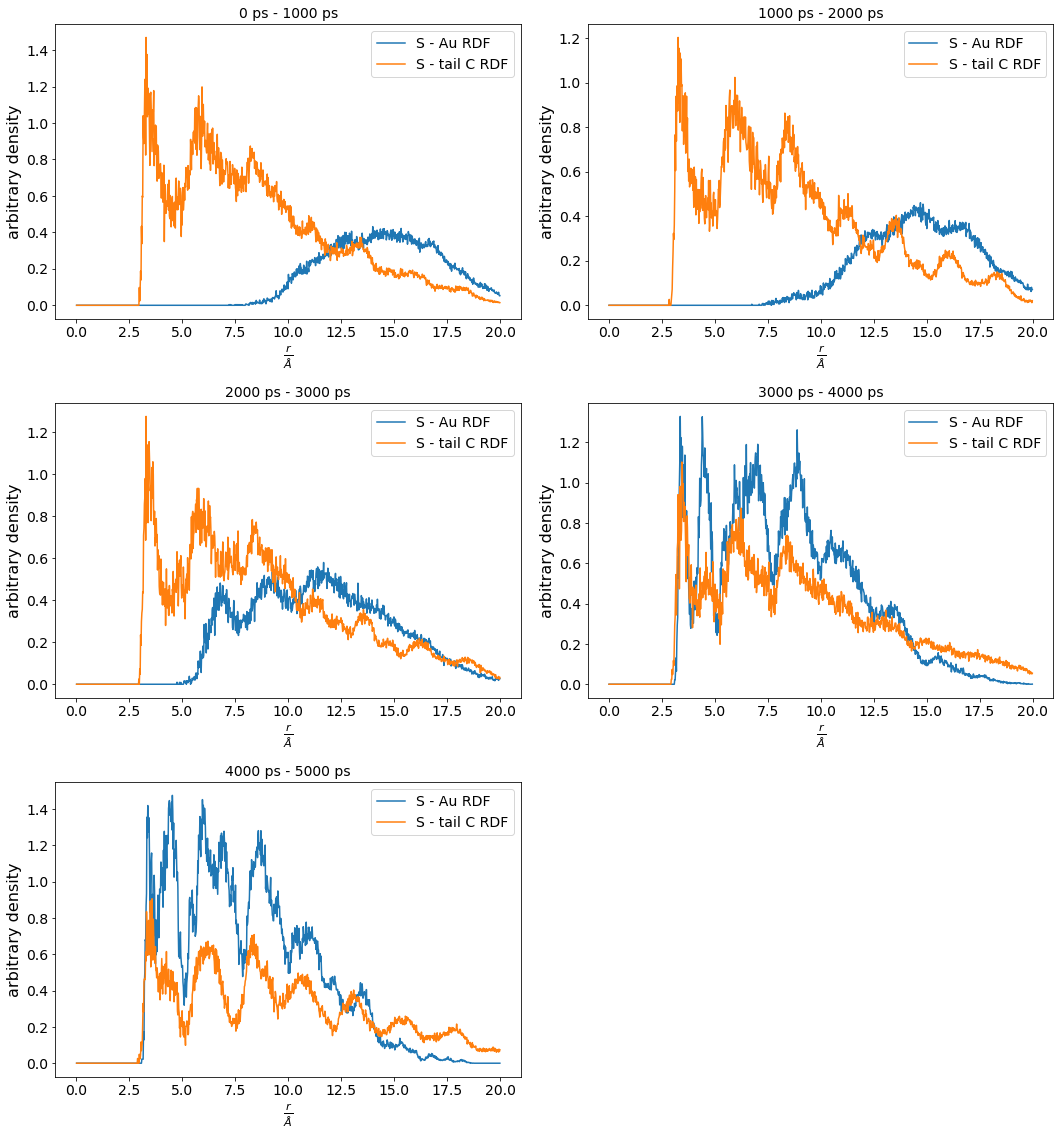

In [176]:
# code snippet for neat plotting of all time-segemtn rdfs
cols = 2
rows = np.ceil(len(rdfSulfurGoldList)/cols).astype(int)
pos = subplotPosition(rows,cols)
fig = plt.figure(figsize=(rows*5,cols*8))

for i, (rdfSulfurGold, rdfTailCarbonGold) in enumerate(zip(rdfSulfurGoldList,rdfTailCarbonGoldList)):
    p = next(pos)
    _, ax = addSubplot(rdf_x,rdfSulfurGold, 
                       legend = "S - Au RDF", 
                       xlabel = r'$\frac{r}{\AA}$', 
                       ylabel='arbitrary density', 
                       title = "{} ps - {} ps".format(i*nSegment,(i+1)*nSegment),
                       fig = fig, pos = p)
    _, _ = addSubplot(rdf_x, rdfTailCarbonGold, 
                      legend="S - tail C RDF",
                      ax = ax, pos = p)
    
fig.tight_layout()

### 4.2. head group sulfur, tail group carbon - water RDF

In [177]:
# Element tuples
element_tuples = [
    ( np.where(chem_sym == 'S')[0][0], np.where(chem_sym == 'O')[0][0] ),
    ( np.where(chem_sym == 'C')[0][0], np.where(chem_sym == 'O')[0][0] ) ]

In [178]:
element_tuples # in atomic numbers

[(16, 8), (6, 8)]

In [179]:
surfactantSolventIndicesOfInterest = water_indices + [ sulfur_index ] + [ tail_carbon_index ]

In [180]:
surfactantSolventRDFs, surfactantSolventRDFx, surfactantSolventRDFobj = piecewiseRDF(
    lmp_trajectrories['npt1ns'], surfactantSolventIndicesOfInterest, element_tuples)

0
1000
2000
3000
4000


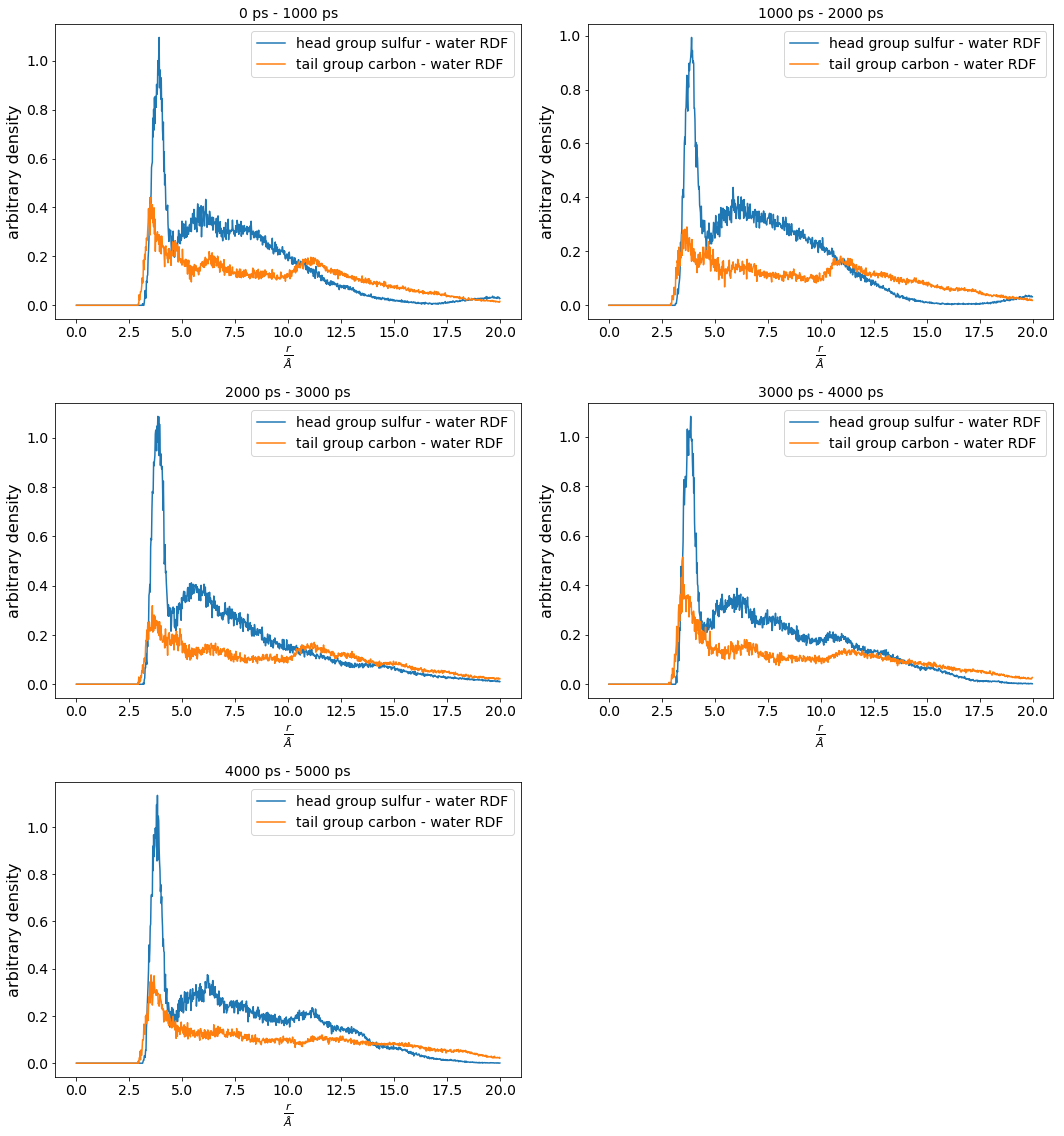

In [181]:
plotPiecewiceRdf(surfactantSolventRDFx, surfactantSolventRDFs, 
                 legend= [ "head group sulfur - water RDF", "tail group carbon - water RDF"]);

### 4.3. Sodium counterion RDF

In [182]:
# Element tuples
counterionRdf_element_tuples = [
    ( np.where(chem_sym == 'Na')[0][0], np.where(chem_sym == 'S')[0][0] ),
    ( np.where(chem_sym == 'Na')[0][0], np.where(chem_sym == 'C')[0][0] ),
    ( np.where(chem_sym == 'Na')[0][0], np.where(chem_sym == 'O')[0][0] ),
    ( np.where(chem_sym == 'Na')[0][0], np.where(chem_sym == 'Au')[0][0] ) ]

In [183]:
counterionRdf_element_tuples

[(11, 16), (11, 6), (11, 8), (11, 79)]

In [184]:
counterionRdfLabels = [ "Na+ counterion - SDS head sulfur RDF", 
                        "Na+ counterion - SDS tail carbon RDF",
                        "Na+ counterion - water oxygen RDF",
                        "Na+ counterion - surface gold RDF"]

In [185]:
counterionRdfIndicesOfInterest = water_indices + surface_indices + \
    ion_indices + [ sulfur_index ] + [ tail_carbon_index ]

In [186]:
counterionRDFs, counterionRDFx, counterionRDFobj = piecewiseRDF(
    lmp_trajectrories['npt1ns'], counterionRdfIndicesOfInterest, counterionRdf_element_tuples)

0
1000
2000
3000
4000


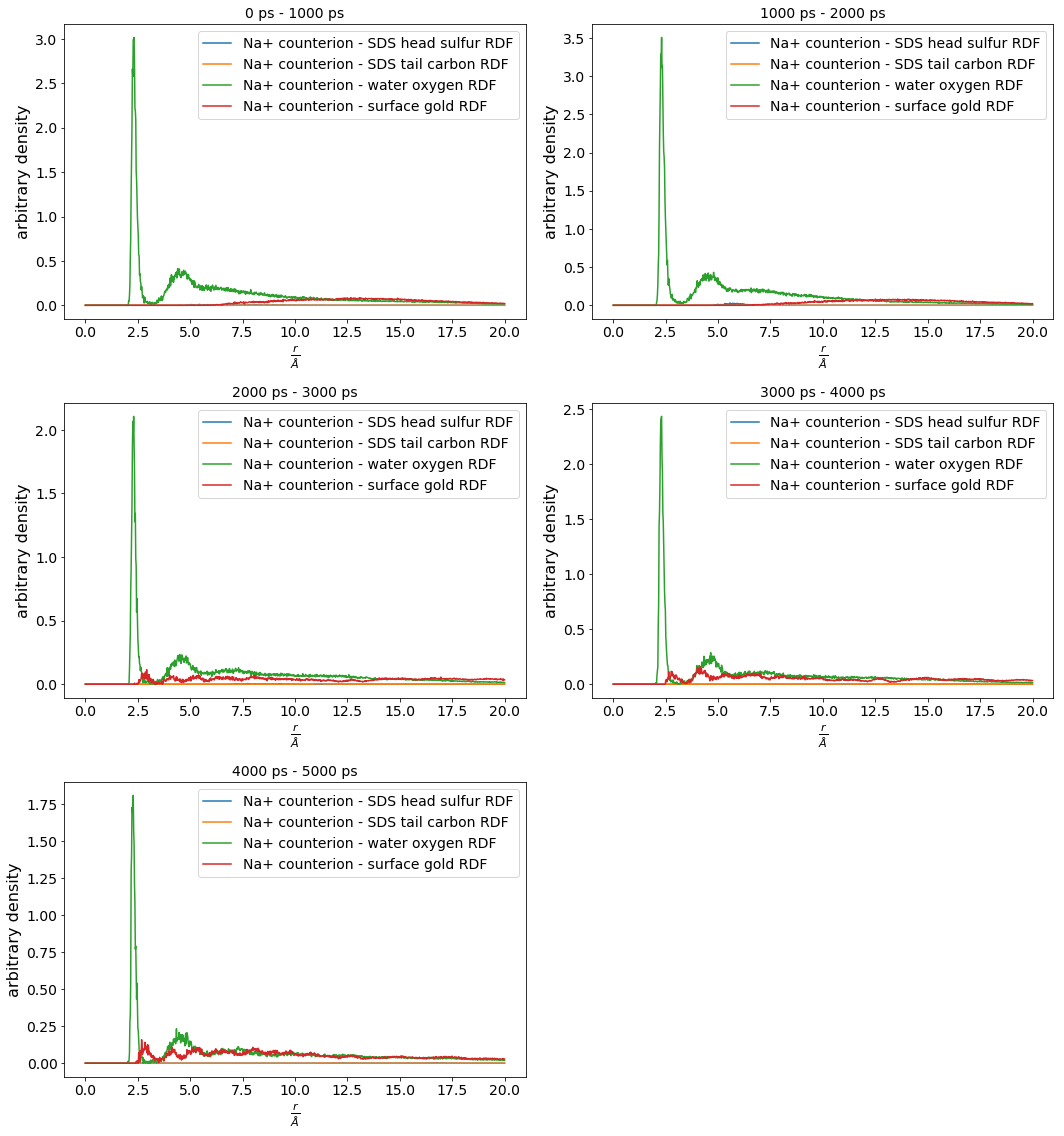

In [187]:
plotPiecewiceRdf(counterionRDFx, counterionRDFs, legend= counterionRdfLabels);

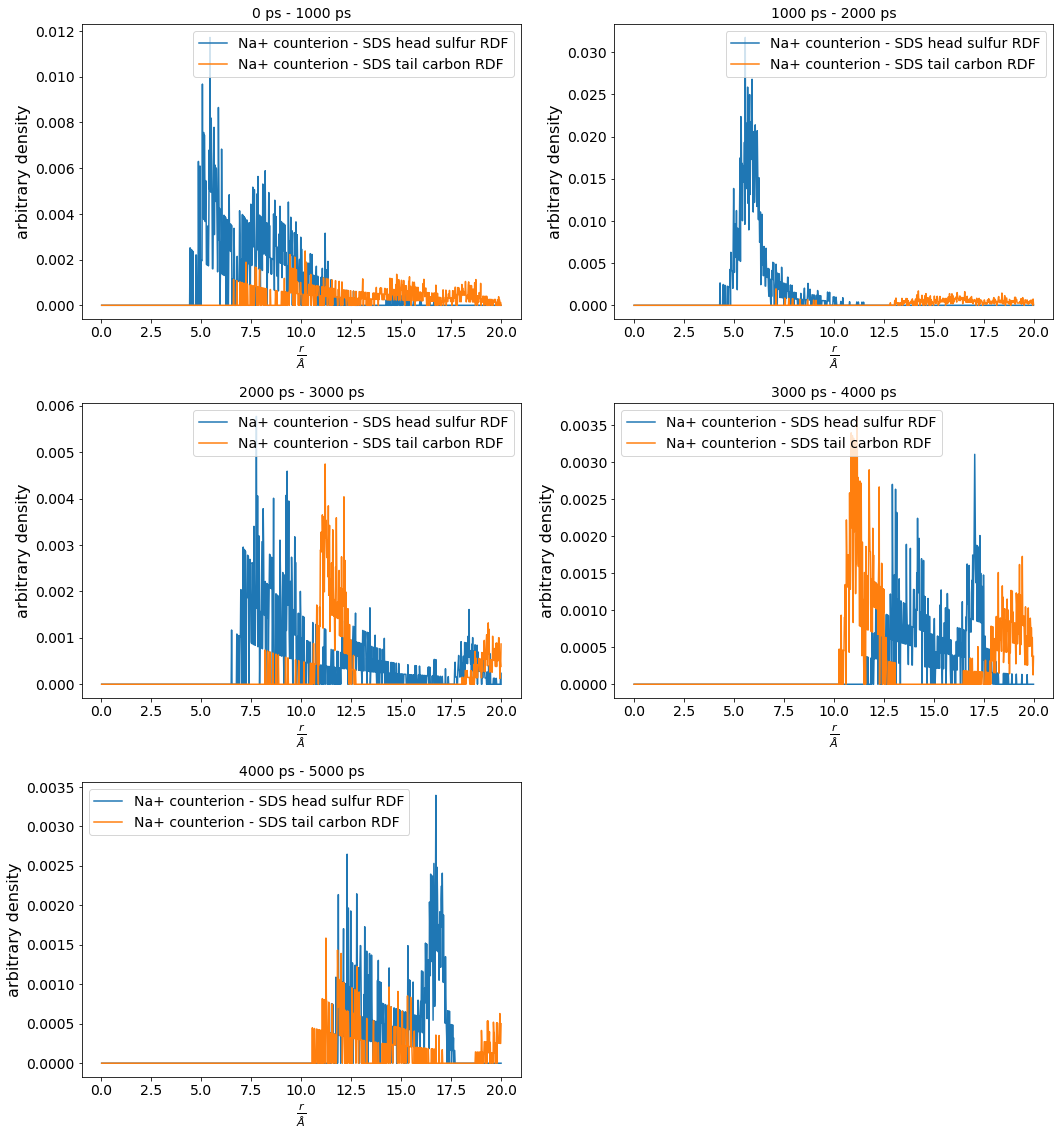

In [189]:
plotPiecewiceRdf(counterionRDFx, counterionRDFs[0:2], 
                 legend= (counterionRdfLabels[0:2]));

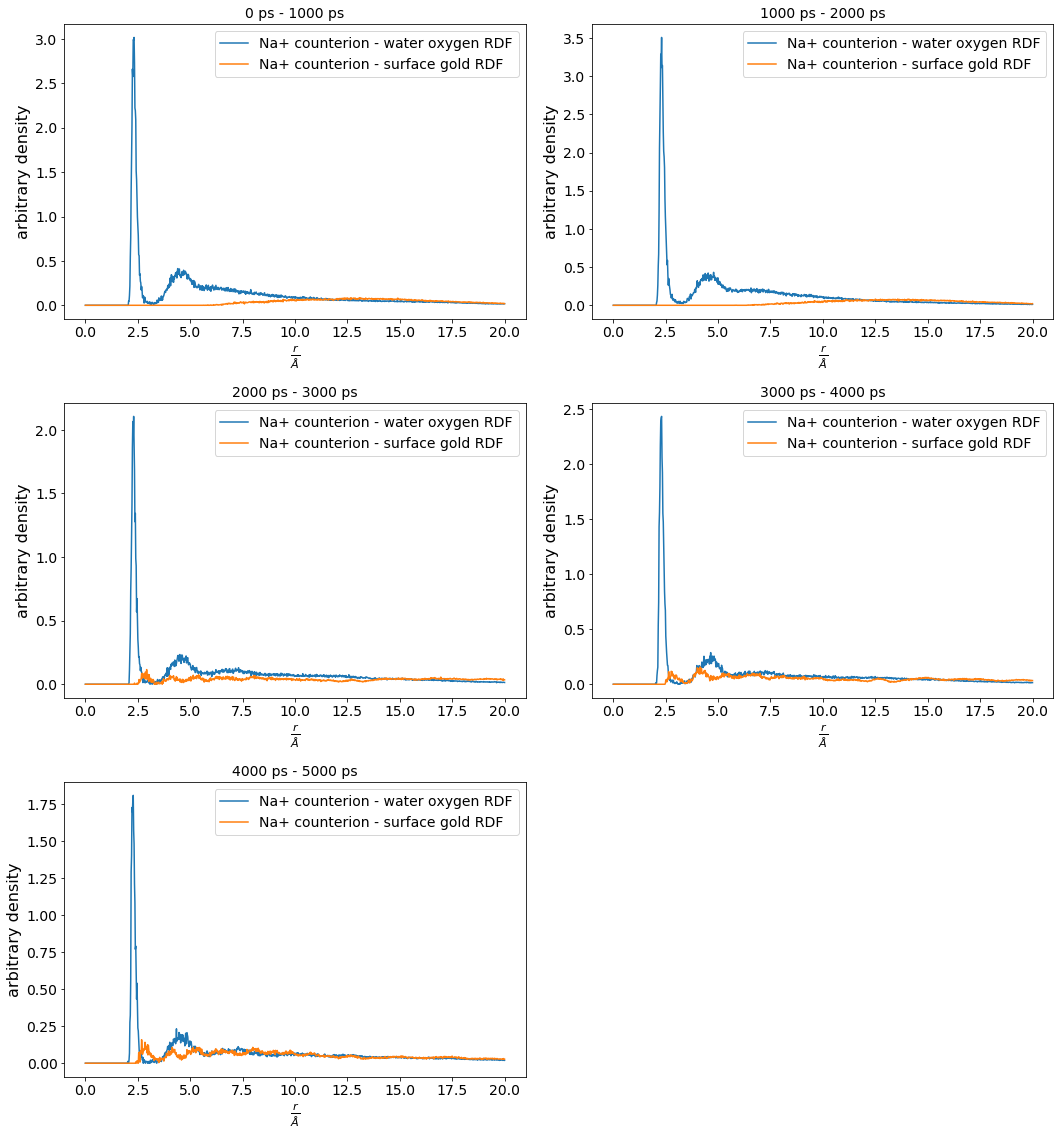

In [190]:
plotPiecewiceRdf(counterionRDFx, counterionRDFs[2:], 
                 legend= (counterionRdfLabels[2:]));

## 5. Distance analysis

### 5.1. Headgroup - gold distance
Head approaches surfaces, apparently "stepwise"

In [191]:
traj = lmp_trajectrories['npt1ns']

In [192]:
traj[0][surfactant_indices].get_atomic_numbers()

array([16,  8,  8, ...,  1,  1,  1])

In [193]:
averageDistanceS2Au, averageDistanceS2AuTimes = piecewiseAveragedDistance(traj,
                                reference_index=sulfur_index,
                                atom_indices=surface_indices,
                                nSegment=50)

In [194]:
len(averageDistanceS2AuTimes)

100

In [195]:
averageDistanceS2Au.shape

(3, 100)

In [196]:
distanceLabels = ['x', 'y', 'z']

Text(0,0.5,'Distance $\\frac{r}{\\AA}$')

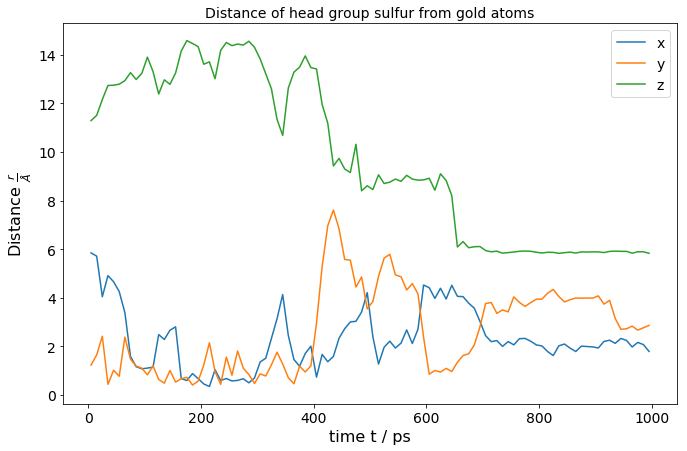

In [197]:
distanceFig = plt.figure()
for i in range(0,3):
    plt.plot( averageDistanceS2AuTimes*0.2, averageDistanceS2Au[i,:], label= distanceLabels[i] )
plt.legend()
plt.title("Distance of head group sulfur from gold atoms")
plt.xlabel("time t / ps")
plt.ylabel(r'Distance $\frac{r}{\AA}$')

In [198]:
traj = lmp_trajectrories['npt1ns']

In [199]:
traj[0][surfactant_indices].get_atomic_numbers()

array([16,  8,  8, ...,  1,  1,  1])

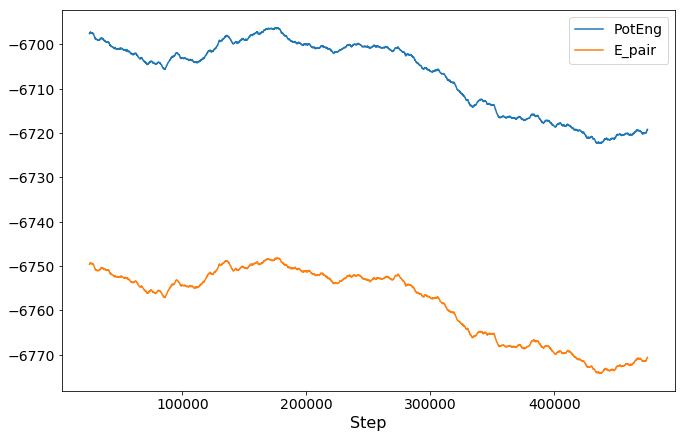

In [201]:
# slight decrease in potential in comparison with approach towards surface
# confirms the anticipated energetically favored adsorption state
nptProduction_1ns_thermo_pd[["PotEng","E_pair"]].rolling(window=5000,center=True).mean().plot()

In [202]:
nptProduction_1ns_thermo_pd

TotEng     KinEng     PotEng       Temp        Press   Enthalpy  \
Step                                                                         
0      -6263.0571  453.10079 -6716.1579  301.79866   798.122940 -6171.1625   
10     -6265.7761  453.21357 -6718.9897  301.87378  -119.442190 -6279.6182   
20     -6263.2673  460.64210 -6723.9094  306.82173   289.621950 -6229.7871   
30     -6267.9400  458.45626 -6726.3962  305.36580 -1420.633000 -6433.0946   
40     -6267.0365  454.66485 -6721.7013  302.84044  1557.912000 -6086.8862   
50     -6267.5204  446.52921 -6714.0497  297.42150  -197.479070 -6290.4505   
60     -6274.3052  436.75049 -6711.0557  290.90815 -1806.958100 -6485.3207   
70     -6274.5247  432.79404 -6707.3187  288.27286  2262.071700 -6012.4026   
80     -6271.3038  432.60558 -6703.9094  288.14733  -767.276420 -6360.7215   
90     -6277.3733  436.87190 -6714.2452  290.98902 -1400.424600 -6440.4945   
100    -6271.7345  461.29208 -6733.0265  307.25467  2055.301600 -6034.5404   
110    -6273.5742  463.61085 -6737.1851  308.79914  -323.591330 -6311.0655   
120    -6276.0452  461.65982 -6737.7050  307.49961  -441.847120 -6327.1367   
130    -6280.6749  459.68075 -6740.3557  306.18140  -637.112930 -6354.4156   
140    -6283.6515  460.93064 -6744.5821  307.01392  1156.133700 -6150.3348   
150    -6287.4721  454.13376 -6741.6059  302.48669  -756.337410 -6374.9679   
160    -6296.9662  452.95837 -6749.9246  301.70380  -801.308860 -6389.5545   
170    -6298.2876  430.20906 -6728.4966  286.55107  1931.707400 -6076.7489   
180    -6302.9410  437.23602 -6740.1770  291.23155 -1420.521800 -6466.9540   
190    -6307.0221  431.59297 -6738.6150  287.47286   915.942100 -6202.1984   
200    -6306.9505  430.02666 -6736.9772  286.42958 -1258.643600 -6452.1378   
210    -6309.5913  420.09868 -6729.6900  279.81681  1169.287600 -6175.6618   
220    -6303.3100  421.50866 -6724.8187  280.75596    72.554129 -6294.9682   
230    -6303.3970  422.26880 -6725.6658  281.26228 -1197.180300 -6441.3359   
240    -6293.9270  423.41199 -6717.3390  282.02372  1159.177500 -6161.0547   
250    -6287.0163  441.90500 -6728.9213  294.34143  -622.037030 -6358.6038   
260    -6278.9437  449.59318 -6728.5368  299.46234     4.150381 -6278.4675   
270    -6270.4279  438.30711 -6708.7350  291.94498   235.898650 -6243.3468   
280    -6260.3922  430.99919 -6691.3914  287.07736   265.349570 -6229.8798   
290    -6251.5076  442.33183 -6693.8394  294.62574    40.789692 -6246.8122   
...           ...        ...        ...        ...          ...        ...   
499710 -6253.0134  437.40051 -6690.4139  291.34111   741.857250 -6165.8642   
499720 -6254.8108  459.86198 -6714.6728  306.30211   181.504630 -6233.5405   
499730 -6259.0044  462.36861 -6721.3730  307.97171 -1675.142400 -6456.5837   
499740 -6262.5737  450.90586 -6713.4796  300.33667  2559.336000 -5963.9443   
499750 -6263.8812  440.69591 -6704.5771  293.53609  -908.432570 -6371.0167   
499760 -6270.7581  426.86339 -6697.6215  284.32261  -494.337360 -6328.8817   
499770 -6271.5294  447.08539 -6718.6148  297.79196   546.610540 -6207.3319   
499780 -6272.5232  445.89931 -6718.4225  297.00194   850.320420 -6172.9345   
499790 -6274.3266  452.19365 -6726.5203  301.19444 -2031.606600 -6513.6513   
499800 -6279.9190  437.87174 -6717.7908  291.65499    14.469685 -6278.2220   
499810 -6273.7231  426.25198 -6699.9751  283.91536  1710.929800 -6073.9294   
499820 -6275.1466  434.14931 -6709.2959  289.17557  -683.052470 -6355.2914   
499830 -6272.3457  446.22269 -6718.5684  297.21734   340.794890 -6232.5669   
499840 -6272.6501  432.20283 -6704.8529  287.87907  -856.983810 -6373.1155   
499850 -6266.1940  444.33626 -6710.5303  295.96083  2374.045800 -5990.7949   
499860 -6263.2341  441.11070 -6704.3448  293.81237 -2625.696400 -6570.8756   
499870 -6264.5047  459.49249 -6723.9971  306.05600   913.565600 -6158.6473   
499880 -6255.2834  449.11794 -6704.4013  299.14579   384.137790 -6210.5924   
499890 -6254.2658  456.27998 -671

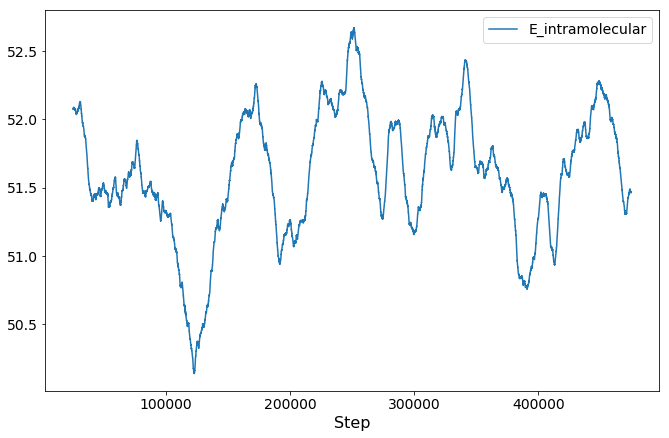

In [203]:
nptProduction_1ns_thermo_pd[["E_intramolecular"]].rolling(window=5000,center=True).mean().plot()

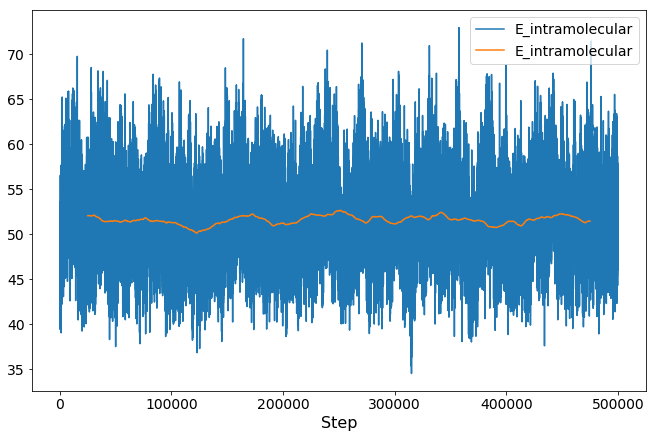

In [204]:
ax = nptProduction_1ns_thermo_pd[["E_intramolecular"]].plot()
nptProduction_1ns_thermo_pd[["E_intramolecular"]].rolling(window=5000,center=True).mean().plot(ax=ax)

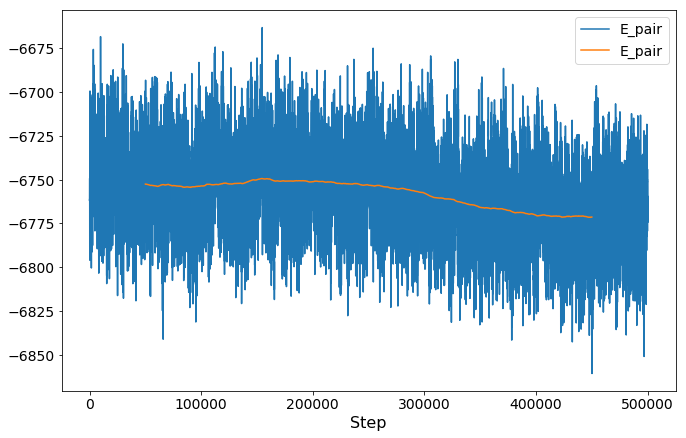

In [205]:
# running average, non-bonded energy
ax = nptProduction_1ns_thermo_pd[["E_pair"]].plot()
nptProduction_1ns_thermo_pd[["E_pair"]].rolling(window=10000,center=True).mean().plot(ax=ax)

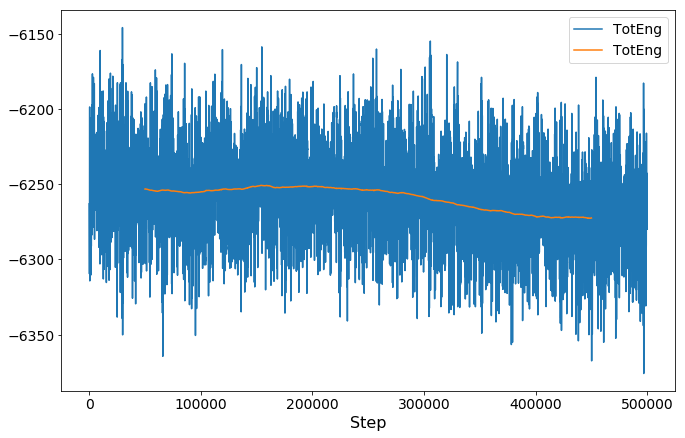

In [206]:
# running average, total energy
ax = nptProduction_1ns_thermo_pd[["TotEng"]].plot()
nptProduction_1ns_thermo_pd[["TotEng"]].rolling(window=10000,center=True).mean().plot(ax=ax)

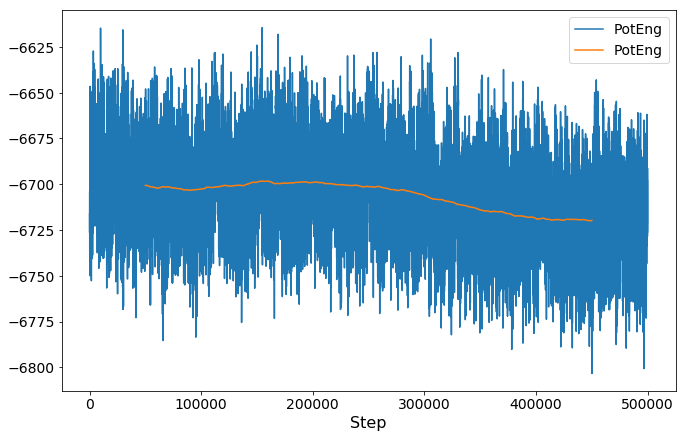

In [207]:
# running average, total energy
ax = nptProduction_1ns_thermo_pd[["PotEng"]].plot()
nptProduction_1ns_thermo_pd[["PotEng"]].rolling(window=10000,center=True).mean().plot(ax=ax)

### 5.2. Tailgroup - gold distance
z - direction: does not change much

In [210]:
averageDistanceTailC2Au, averageDistanceTailC2AuTimes = piecewiseAveragedDistance(traj,
                                reference_index=tail_carbon_index,
                                atom_indices=surface_indices,
                                nSegment=50)

Text(0,0.5,'Distance $\\frac{r}{\\AA}$')

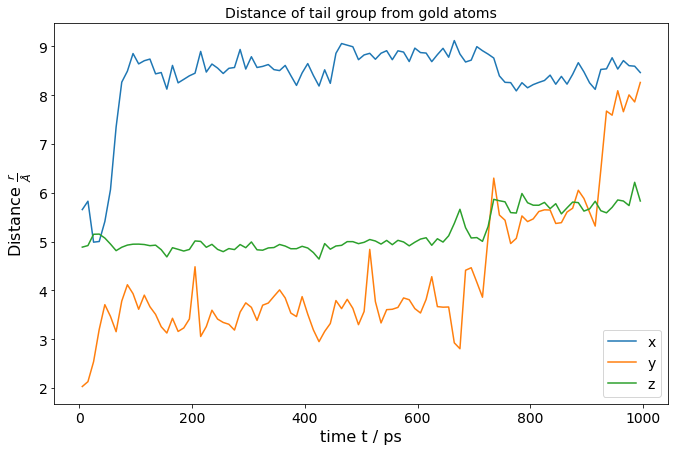

In [211]:
for i in range(0,3):
    plt.plot( averageDistanceTailC2AuTimes*0.2, averageDistanceTailC2Au[i,:], label= distanceLabels[i] )
plt.legend()
plt.title("Distance of tail group from gold atoms")
plt.xlabel("time t / ps")
plt.ylabel(r'Distance $\frac{r}{\AA}$')

### 5.3. Surface COM - Surfactant COM distance

In [212]:
averageDistanceComCom, averageDistanceComComTimes = piecewiseAveragedComComDistance(traj,
                                surfactant_indices,surface_indices,
                                nSegment=50)

Text(0,0.5,'Distance $\\frac{r}{\\AA}$')

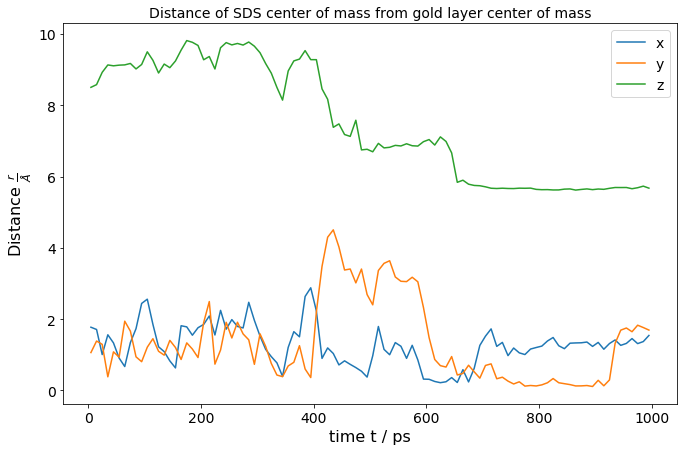

In [213]:
for i in range(0,3):
    plt.plot( averageDistanceComComTimes*0.2, averageDistanceComCom[i,:], label= distanceLabels[i] )
plt.legend()
plt.title("Distance of SDS center of mass from gold layer center of mass")
plt.xlabel("time t / ps")
plt.ylabel(r'Distance $\frac{r}{\AA}$')

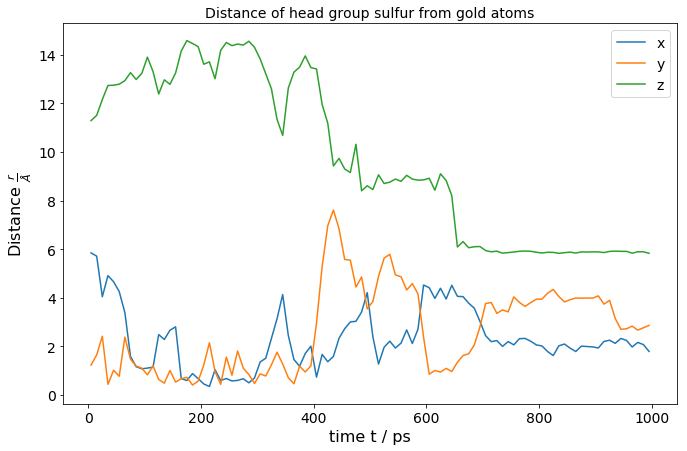

In [215]:
# for comparison: Headgroup - surface distance: 
distanceFig

### SDS chain length

In [216]:
averageChainLength, averageChainLengthTimes = piecewiseAveragedDistance(traj,
                                reference_index=tail_carbon_index,
                                atom_indices=[sulfur_index],
                                nSegment=50)

In [217]:
np.linalg.norm(averageChainLength,axis=0)

array([ 13.19284389,  13.30118302,  11.45347917, ...,  15.15614958,
        15.05356845,  15.03744343])

In [218]:
np.linalg.norm(averageChainLength,axis=0).shape

(100,)

Text(0,0.5,'Distance $\\frac{r}{\\AA}$')

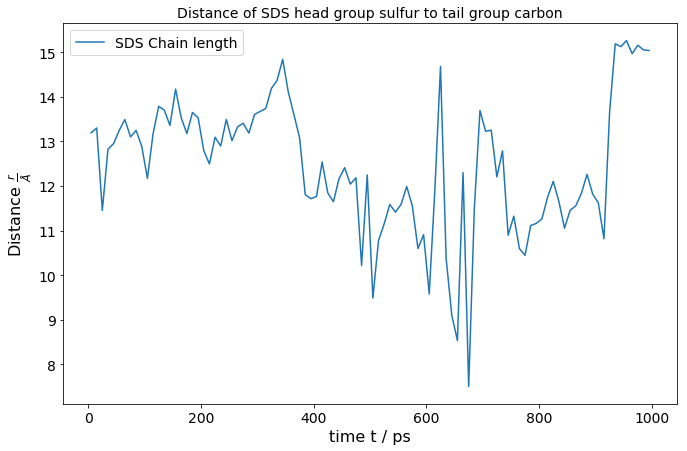

In [219]:
plt.plot( averageChainLengthTimes*0.2, 
         np.linalg.norm(averageChainLength,axis=0), label="SDS Chain length")
plt.legend()
plt.title("Distance of SDS head group sulfur to tail group carbon")
plt.xlabel("time t / ps")
plt.ylabel(r'Distance $\frac{r}{\AA}$')

## MSD and diffusivities

In [220]:
dt

2e-15

In [221]:
T = 1e-9 # 1 ns

In [222]:
Nf = len(traj) - 1 # number of stored frames, corresponds to 1ns

In [223]:
Nf

5000

In [224]:
Ns = T/dt # number of steps

In [225]:
Ns

500000.0

In [226]:
StepsPerFrame = Ns / Nf

In [227]:
StepsPerFrame

100.0

In [228]:
TimePerFrame = StepsPerFrame*dt

In [229]:
TimePerFrame

2e-13

In [235]:
# displacements over fixed time spans, i.e. from each frame to the 50th or 5th following frame

In [230]:
displacement10ps = comDisplacement(traj, surfactant_indices, dt=50)

In [231]:
displacement1ps = comDisplacement(traj, surfactant_indices, dt=5)

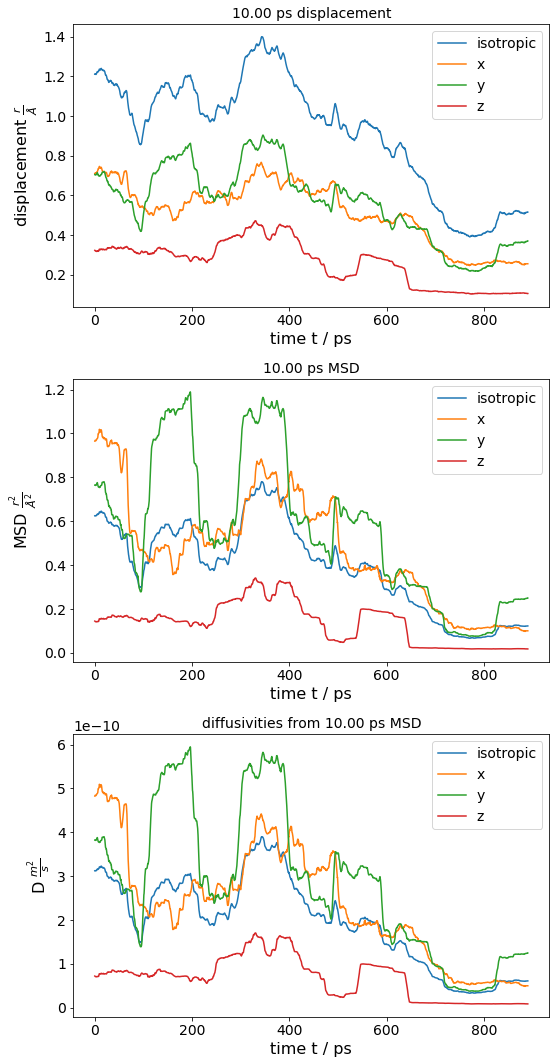

In [232]:
# instead of averaging over many trajectories, we average over N time-wise close frames-frame displacements
# crude (all displacements within each set very correlated)
# default N = 500 ~ 1 ps
evaluateDisplacement(displacement10ps, dt=50);
# however, the results give a good idea about anisotropic and decreasing mobility 
# during approach towards surface

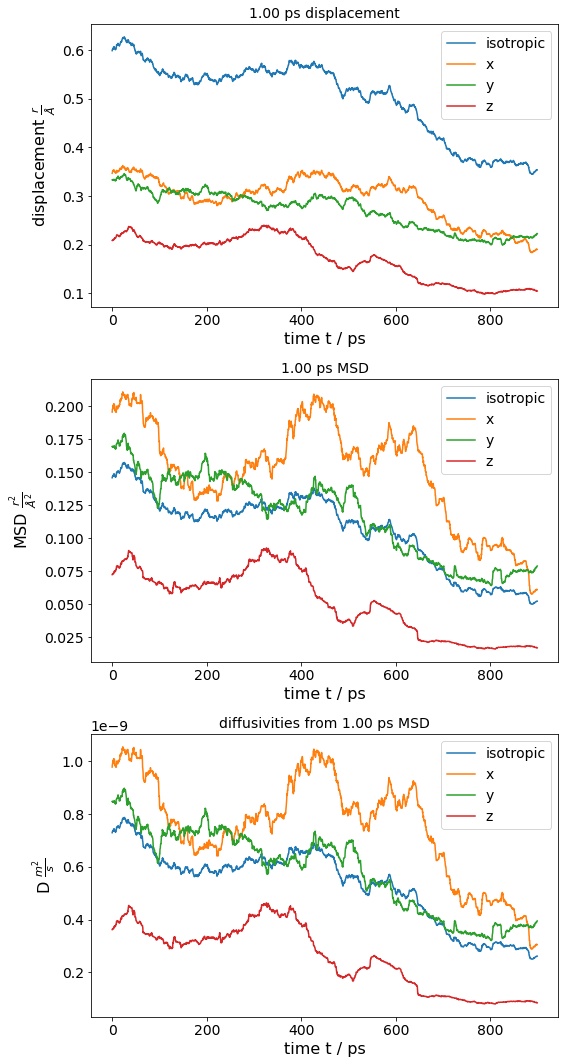

In [233]:
evaluateDisplacement(displacement1ps, dt=5);

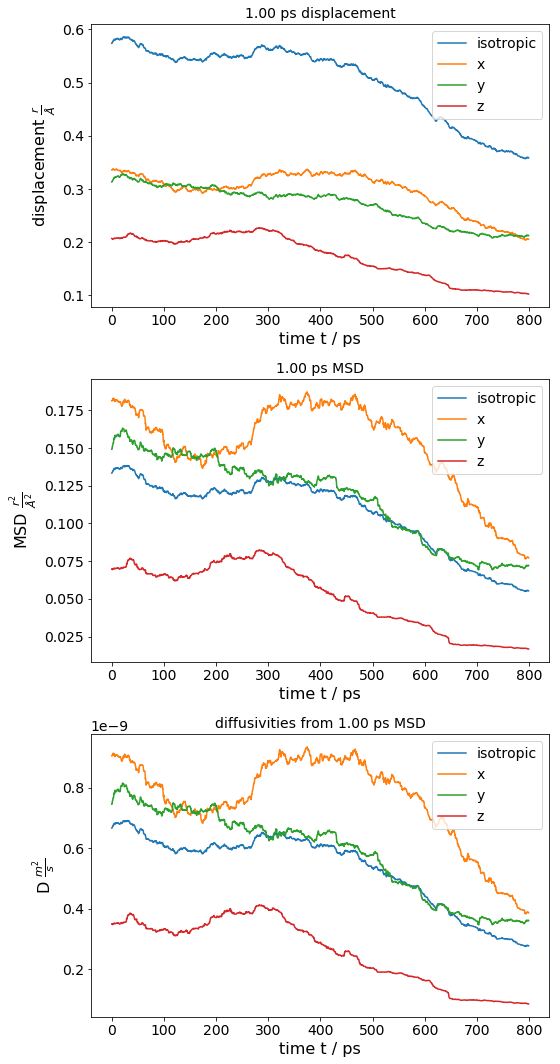

In [234]:
evaluateDisplacement(displacement1ps, dt=5, window=1000);